In [1]:
# sys.argv[1] = <simulation file name>
script = False
cluster = False

In [2]:
import sys
import math
import statistics
import matplotlib.pyplot as plt
import numpy as np
from numpy.ma import masked_array
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from astropy.io import fits
from astropy.visualization import make_lupton_rgb
from astropy.table import Table

plt.style.use('dark_background')

In [3]:
# set file path
if cluster:
    filepath=''
else:
    filepath = '/Users/gilliancartwright/Desktop/Research/Segmentation/Image-Segmentation/'

# set file name and use correct loading bar
if script:
    filename = sys.argv[1]
    from tqdm import tqdm
else:
    filename = filepath + 'simulation_file.fits'
    from tqdm.notebook import tqdm

# get data from fits
hdu_list = fits.open(filename)
complete_sim = hdu_list[1].data
source_sim = hdu_list[2].data
lens_sim =hdu_list[3].data
data = pd.DataFrame(hdu_list[4].data)
hdu_list.close()

coadd_list = data["Y6_COADD_OBJECT_ID"].values.tolist()
NUM_PIX = 45  # pixels per axis
DELTA_PIX = 0.2637  #  pixel size in arcsec

In [4]:
def normalize(flat):
    """
    Normalize a 1D numpy array between 0-1
    Args:
        * flat {numpy 1D array}: array to be normalized
    Returns: normalized 1D numpy array
    """
    MIN = np.min(flat)
    MAX = np.max(flat)
    for i in range(len(flat)):
        flat[i] = (flat[i]-MIN)/(MAX-MIN)

    return flat



In [5]:
def rgb_graphs(sim_i, sim_r, sim_g, cutout_i, cutout_r, cutout_g):
    """
    Plot three rgb plots per object: source simulation, lens cutout, and combined
    Args:
        * sim_i: i-band source light simulation
        * sim_r: r-band source light simulation
        * sim_6: g-band source light simulation
        * cutout_i: i-band lens cutout
        * cutout_r: r-band lens cutout
        * cutout_g: g-band lens cutout
    Returns: RGB image of complete simulation
    """
    sim_rgb = make_lupton_rgb(sim_i, sim_r, sim_g, Q=11., stretch=40.)
    cutout_rgb = make_lupton_rgb(cutout_i, cutout_r, cutout_g, Q=11., stretch=40.)
    rgb = make_lupton_rgb(sim_i+cutout_i, sim_r+cutout_r, sim_g+cutout_g, Q=11., stretch=40.)

    # if in notebook, show plots
    if script == False:
        loc = plticker.MultipleLocator(base=3.75)
        fig, ax = plt.subplots(figsize=(15, 4), ncols=3)
        
        ax[0].set_title('Source(s)')
        ax[0].axis('off')
        ax[0].imshow(sim_rgb, aspect='equal')

        ax[1].set_title('Lens')
        ax[1].axis('off')
        ax[1].imshow(cutout_rgb, aspect='equal')

        ax[2].set_title('Complete Simulation')
        ax[2].axis('off')
        ax[2].imshow(rgb, aspect='equal')

        plt.show()
        plt.close()

    return rgb



In [6]:
def create_source_mask(image):
    """
    Create mask that marks where source light is
    Args:
        * image {(3, pix, pix) numpy array}: 3-channel (rgb) simulated source
        * MIN {float}: value between 0-1 that sets cut-off for source light
    Returns {2D numpy array}: source mask
    """
    # turn image into normalized list
    super_image = np.add(image[0], np.add(image[1], image[2]))
    pix_list = super_image.flatten()
    normalized = normalize(pix_list)

    # re-normalize
    MIN=0.2
    for i in range(len(pix_list)):
        if normalized[i] > MIN:  # pixel has light value
            pix_list[i] = pix_list[i] # normalized value between 0-1
        else:
            pix_list[i] = 0

    # turn masked list back into 2d shape
    masked = np.reshape(pix_list, image[0].shape)

    return masked



In [7]:
def lens_and_background_mask(image, row, cutoff):    
    """
    Create a mask that marks pixels as 'lens' or 'noise' classes
    Args:
        * image {(3, pix, pix) array}: rgb lens cutout
        * row {int}: row of data table to get i-band flux radius
        * cutoff {float}: number of sigma above average that pixels are considered 
                          'lens' or 'noise'
                          * 'noise' get additional 0.1 sigma
                             to avoid marking 'lens' pixels as 'noise'
    Returns {(pix, pix) array}: array of mask for lens and noise
    """
    # make a list of coordinates (not arcsec)
    pix = len(image[0, :, 0])
    start = -(np.floor(0.5*pix))
    end = np.ceil(0.5*pix)
    X2d, Y2d = np.meshgrid(np.arange(start, end), np.arange(start, end))
    coords = np.column_stack((Y2d.ravel(), X2d.ravel())).tolist()

    # make list of distances to center from coordinate list
    dist_from_center = []
    for i in range(len(coords)):
        distance = np.sqrt(coords[i][0] ** 2 + coords[i][1] ** 2)
        dist_from_center.append(distance)

    # turn image into normalized list
    super_image = np.add(image[0], np.add(image[1], image[2]))
    pix_list = super_image.flatten()
    normalized = normalize(pix_list)

    # set light value cutoff
    mean = np.mean(normalized)
    stdev = np.std(normalized)
    lens_cutoff = mean + cutoff * stdev
    noise_cutoff = mean + (cutoff+0.1) * stdev

    # set max radius to look for lens light:
    #     if distance to farthest source image is smaller than 1.2*(avg. flux radius),
    #     then use 1.2*(avg. flux radius) as lens light radius
    f_radius = np.mean([data.iloc[row, 7:10]])  # average flux radius across g, r, i bands
    radius_p = data['POSITION1'].iloc[row]  # distance from center to farthest source image

    # experimentation has shown that just using average flux rad. is too small, so use 1.2*flux rad.
    min_multiply = 1.2
    min_rad = min_multiply * f_radius
    if radius_p < min_rad:
        radius = min_rad
        if script == False:  # for testing purposes
            print(f'{min_multiply} * flux radius: {radius}')

    else:
        radius = radius_p
        if script == False:  # for testing purposes
            print(f'position1: {radius}')

    # iterate through pixels and set corresponding values
    lens_coords = []
    lens_list = np.zeros(len(pix_list))
    noise_coords = []
    noise_list = np.zeros(len(pix_list))
    loop_count = 0

    # while less than 20 pixels are marked as 'lens',
    # continue to lower the cutoff value until enough pixels are 'lens'
    while len(lens_coords) <= 20:
        # catch infinite loop
        if loop_count > 15:
            lens_cutoff = 0.001  # any pixel with light value in radius will be marked lens
            radius = radius + 5  # widen radius in case too small
            print(f"ERROR! ID: {row['Y6_COADD_OBJECT_ID']}")  # flag as 'ERROR'

        # iterate through pixels to look for 'lens' within circle of 'radius'
        for i in range(len(pix_list)):
            if normalized[i] > lens_cutoff and dist_from_center[i] < radius:
                lens_coords.append(i)  # mark coordinate as 'lens'
                lens_list[i] = pix_list[i]  # update 'lens' with pixel val

        # lower light value thresholds
        lens_cutoff -= 0.02
        noise_cutoff -= 0.015
        
        # fix thresholds if too small
        if lens_cutoff < 0.005:
            lens_cutoff = 0.005
            noise_cutoff = 0.02

        if len(lens_coords) <= 20:
            if script == False:
                print('REPEATING LOOP')  # for testing
            loop_count += 1  # for catching infinite loop

    # look through the pixels not marked as 'lens'
    for i in range(len(pix_list)):
        if i not in lens_coords and dist_from_center[i]>(radius+1):
            if normalized[i] > noise_cutoff:  # mark as 'noise'
                noise_coords.append(i)
                noise_list[i] = pix_list[i]

    # reshape into original size
    lens = np.reshape(lens_list, (pix, pix))
    noise = np.reshape(noise_list, (pix, pix))

    return lens, noise



In [8]:
def mask_image(coadd_id, cutoff, pix):
    """
    Mask a single image so each pixel is categorized as 'source', 'lens', or 'noise'
    Args:
        * coadd_id: 'Y6_COADD_OBJECT_ID' of candidate
        * noise_cutoff: pixels outside 2(flux rad) that are greater than
                        noise_cutoff are marked as noise
        * lens_cutoff: pixels within 2(flux rad) > that are greater than 
                       lens_cutoff are marked as lens light
    Returns: 
        * rgb: rgb graphs of original source simulation, lens, and complete image
        * masked_source: 2d np array marking pixels where source light is
        * masked_lens: 2d np array marking pixels where lens and nosie is
        * masked: 2d np array with complete image labeled for source, lens, and noise
    """
    # index by coadd_id
    row = data[data['Y6_COADD_OBJECT_ID'] == coadd_id].index[0]

    # original simulation
    source_g, source_r, source_i = source_sim[row][0], source_sim[row][1], source_sim[row][2]
    lens_g, lens_r, lens_i = lens_sim[row][0], lens_sim[row][1], lens_sim[row][2]
    rgb = rgb_graphs(source_i, source_r, source_g, lens_i, lens_r, lens_g)

    # apply masks to source and lens
    masked_source = create_source_mask(source_sim[row])
    masked_lens, masked_noise = lens_and_background_mask(lens_sim[row], row, cutoff)
    
    # ensure each pixel belongs to ONLY ONE class
    source_list = masked_source.flatten()  # 0
    lens_list = masked_lens.flatten()  # 1
    noise_list = masked_noise.flatten()  # 2
    for i in range(len(source_list)):
        if source_list[i] > 0:
            if noise_list[i] >= source_list[i]:
                source_list[i], lens_list[i], noise_list[i] = 0, 0, 1

            elif lens_list[i] >= source_list[i]:
                source_list[i], lens_list[i], noise_list[i] = 0, 1, 0

            else:
                source_list[i], lens_list[i], noise_list[i] = 1, 0, 0

        elif noise_list[i] > 0:
            source_list[i], lens_list[i], noise_list[i] = 0, 0, 1

        elif lens_list[i] > 0:
            source_list[i], lens_list[i], noise_list[i] = 0, 1, 0

        else:
            source_list[i], lens_list[i], noise_list[i] = 0, 0, 0

    # combine and reshape
    masked = np.empty((3, pix, pix))
    masked[0] = np.reshape(source_list, masked[0].shape)  # 0
    masked[1] = np.reshape(lens_list, masked[1].shape)  # 1
    masked[2] = np.reshape(noise_list, masked[2].shape)  # 2

    # plot if in notebook
    if script == False:
        fig, ax = plt.subplots(1, 3, figsize=(15, 4))

        img1 = ax[0].imshow(masked_source, cmap='magma')
        ax[0].set_title('Source(s) Mask')
        ax[0].axis('off')

        smooth_lens = masked_array(masked_lens, masked_lens==0)  # when lens is 1 show lens
        smooth_noise = masked_array(masked_noise, masked_noise==0)  # when noise is 1 show noise
        
        ax[1].imshow(smooth_lens, interpolation='nearest', cmap='spring')
        ax[1].imshow(smooth_noise, interpolation='nearest', cmap='summer')
        ax[1].set_title('Lens Mask')
        ax[1].axis('off')
        
        lens = masked_array(masked[1], masked[1]!=1)  # when lens is 1 show lens
        noise = masked_array(masked[2], masked[2]!=1)  # when noise is 1 show noise

        ax[2].imshow(masked[0], interpolation='nearest', cmap='magma')
        ax[2].imshow(lens, interpolation='nearest', cmap='spring')
        ax[2].imshow(noise, interpolation='nearest', cmap='summer')
        ax[2].set_title('All Masks')
        ax[2].axis('off')

        plt.show()
    
    return rgb, masked

In [9]:
def masking_all(pix, num):
    """
    Mask [num] simulations & show progress bar
    Args:
    * pix {int}: pixels per axis
    * num {int}: number of images to mask
    Returns:
    """
    masks_source = np.zeros((1, pix, pix))
    masks_lens = np.zeros((1, pix, pix))
    masks_noise = np.zeros((1, pix, pix))
    masks_complete = np.zeros((1, 3, pix, pix))

    with tqdm(total=num) as pbar:
        for (index, row) in data[:num].iterrows():
            rgb, masked = mask_image(row['Y6_COADD_OBJECT_ID'], 1.7, pix)  # cutoff=1.7 sigma above avg.
            if not script:  # for testing purposes
                print(row['Y6_COADD_OBJECT_ID'])
            masks_source = np.append(masks_source, [masked[0]], axis=0)
            masks_lens = np.append(masks_lens, [masked[1]], axis=0)
            masks_noise = np.append(masks_noise, [masked[2]], axis=0)
            masks_complete = np.append(masks_complete, [masked], axis=0)

            pbar.update(1)

    masks_source = np.delete(masks_source, 0, axis=0)
    masks_lens = np.delete(masks_lens, 0, axis=0)
    masks_complete = np.delete(masks_complete, 0, axis=0)
    
    return(masks_complete, masks_source, masks_lens)


In [10]:
def write_fit_file(name, images, data):
    """
    writes fits file with simulation data, simulation images, and mask images
    """
    my_types = {'Y6_COADD_OBJECT_ID': int, 'TILENAME': str, 'HPIX_16384': int, 'HPIX_4096': int,
       'DNF_ZMEAN_SOF': float, 'RA': float, 'DEC': float, 'FLUX_RADIUS_G': float, 'FLUX_RADIUS_R': float,
       'FLUX_RADIUS_I': float, 'FLUX_RADIUS_Z': float, 'KRON_RADIUS': float, 'GAP_FLUX_G': float,
       'MOF_BDF_FLUX_G': float, 'MOF_PSF_FLUX_G': float, 'SOF_BDF_FLUX_G': float, 'SOF_PSF_FLUX_G': float,
       'MAG_AUTO_G': float, 'MAG_APER_4_G': float, 'MAG_APER_8_G': float, 'SOF_BDF_G_1': float,
       'Y3_COADD_OBJECT_ID': int, 'REFMAG': float, 'REFMAG_ERR': float, 'LUM': float, 'ZREDMAGIC': float,
       'ZREDMAGIC_E': float, 'CHISQ': float, 'Z_LENS': float, 'MAG_G': float, 'MAG_R': float, 'MAG_I': float, 'MAG_Z': float,
       'MAG_ERR_G': float, 'MAG_ERR_R': float, 'MAG_ERR_I': float, 'MAG_ERR_Z': float, 'ZG': float, 'ZR': float, 'ZI': float,
       'ZZ': float, 'SOF_BDF_G_2': float, 'IMAFLAGS_ISO_G': int, 'IMAFLAGS_ISO_R': int,
       'IMAFLAGS_ISO_I': int, 'IMAFLAGS_ISO_Z': int, 'EXT_COADD': int, 'FWHM_WMEAN_G': float,
       'FWHM_WMEAN_R': float, 'FWHM_WMEAN_I': float, 'FWHM_WMEAN_Z': float, 'SKYBRITE_WMEAN_G': float,
       'SKYBRITE_WMEAN_R': float, 'SKYBRITE_WMEAN_I': float, 'SKYBRITE_WMEAN_Z': float, 'Z1': float, 'LENSED_MAG': float,     
       'mag_1': float, 'ISOLATION': float, 'EINSTEIN_RADIUS': float, 'MAGNIFICATION': float, 'POSITION1': float}
    data = data.astype(my_types)
    
    sim_images, source_images, lens_images = images[0], images[1], images[2]
    
    primary = fits.PrimaryHDU()
    image1 = fits.ImageHDU(images[0], name="IMAGE")
    image2 = fits.ImageHDU(images[1], name="IMAGE")
    image3 = fits.ImageHDU(images[2], name="IMAGE")
    image4 = fits.ImageHDU(images[3], name="IMAGE")
    image5 = fits.ImageHDU(images[4], name="IMAGE")
    image6 = fits.ImageHDU(images[5], name="IMAGE")
    table_data = Table.from_pandas(data)
    table = fits.BinTableHDU(data = table_data)
    hdu_list = fits.HDUList([primary, image1, image2, image3, image4, image5, image6, table])
    hdu_list.writeto(name + '.fits', overwrite=True)   
    hdu_list.close()

  0%|          | 0/40 [00:00<?, ?it/s]

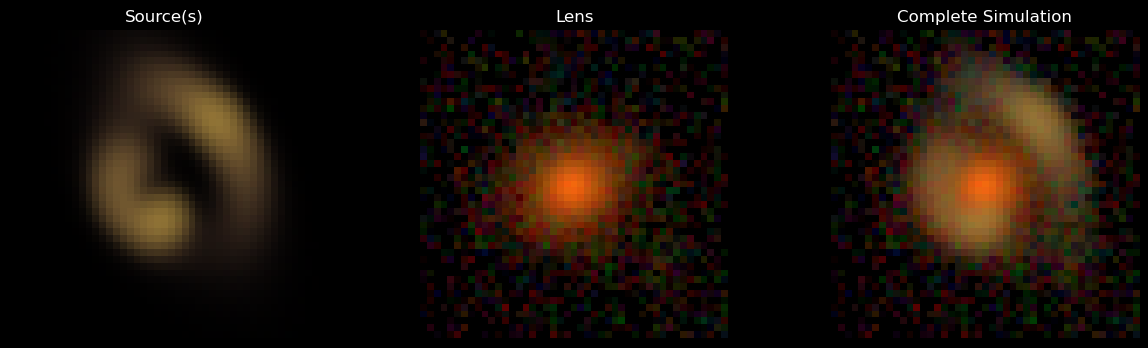

1.2 * flux radius: 5.385762408000001


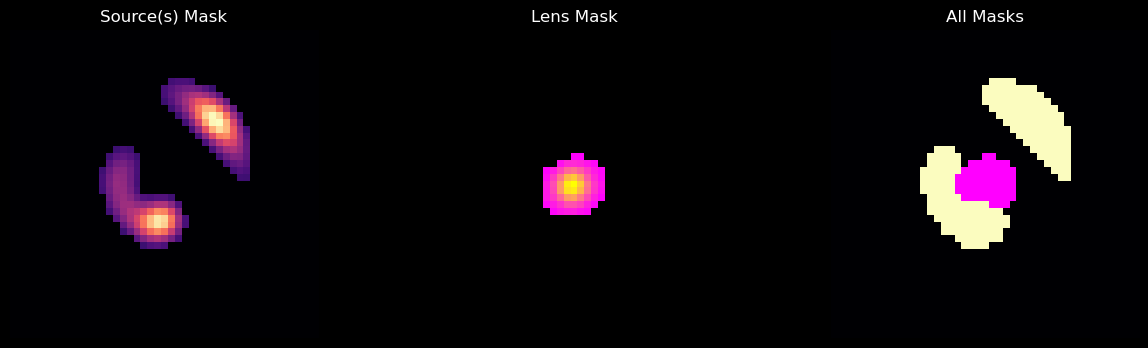

966802453


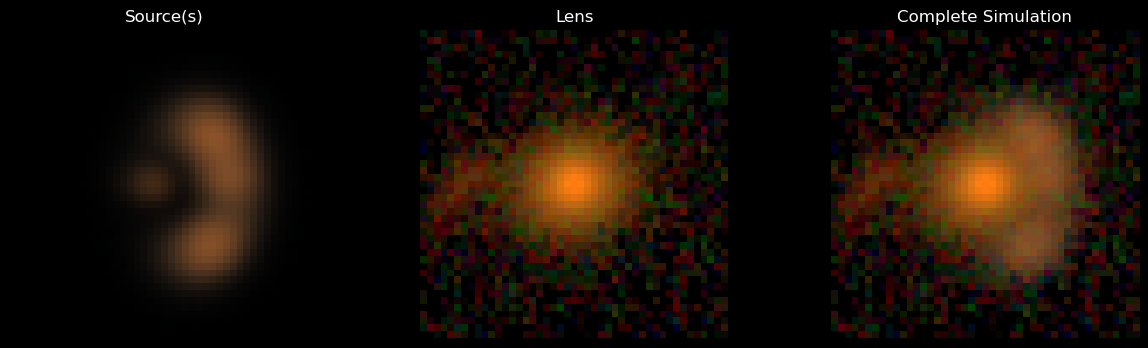

1.2 * flux radius: 4.95905466


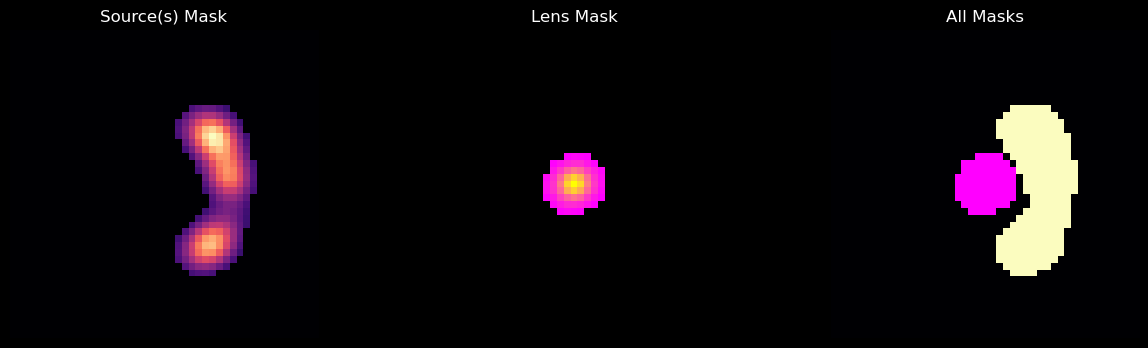

1253235938


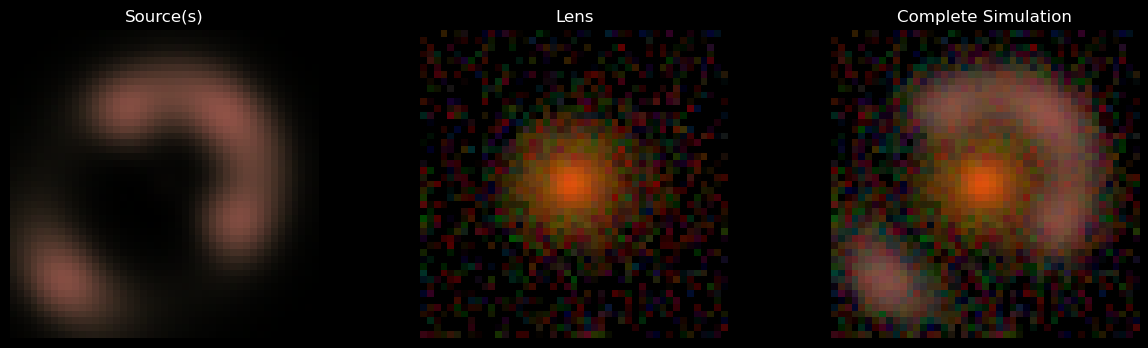

1.2 * flux radius: 6.691650392


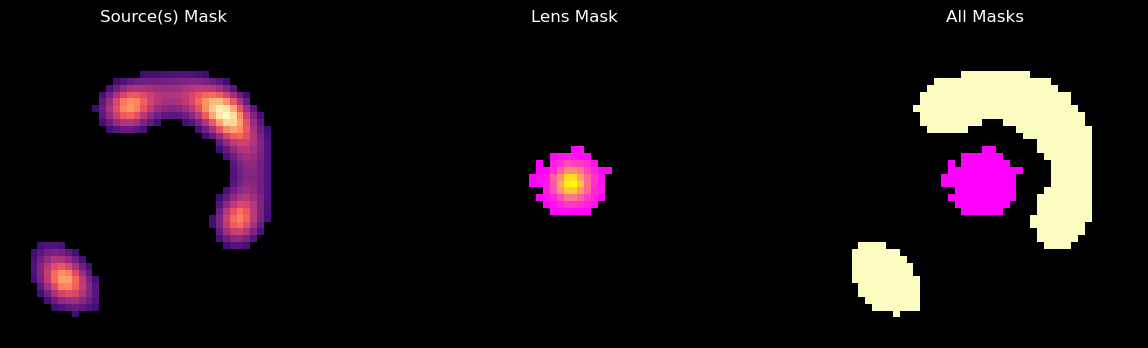

1177791444


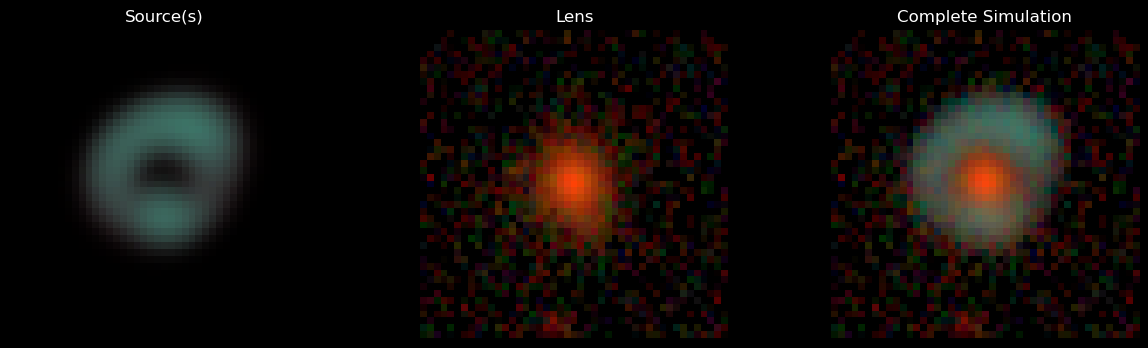

1.2 * flux radius: 4.962619491999999


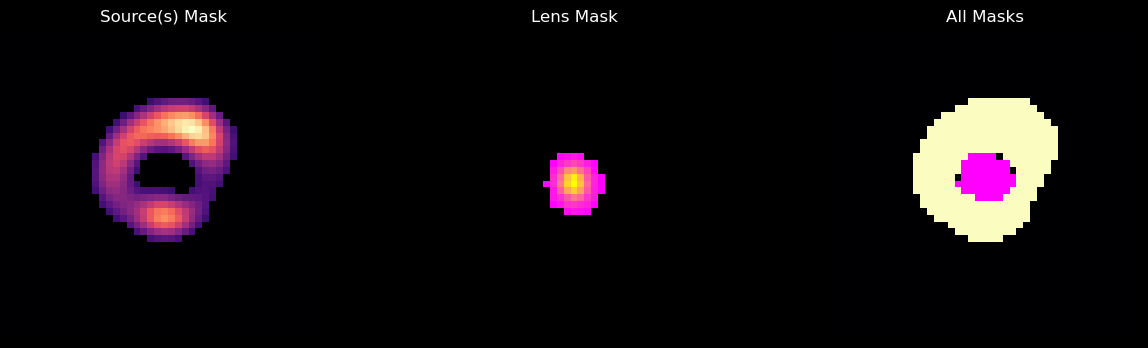

1353299473


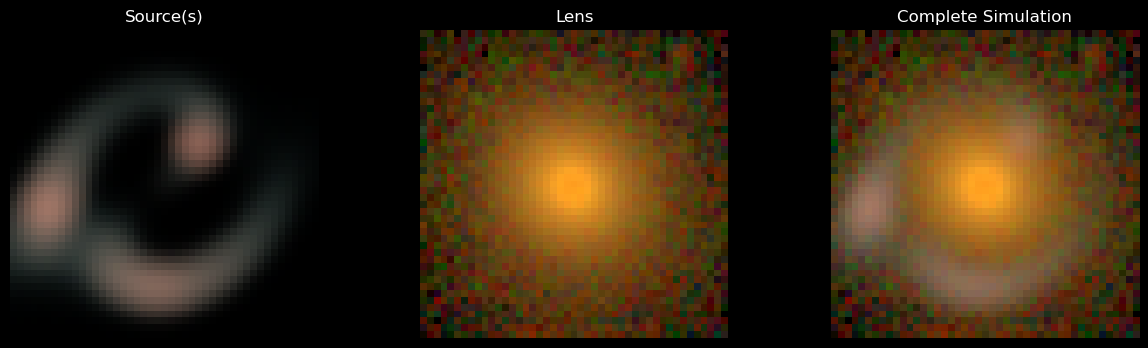

1.2 * flux radius: 8.314851948


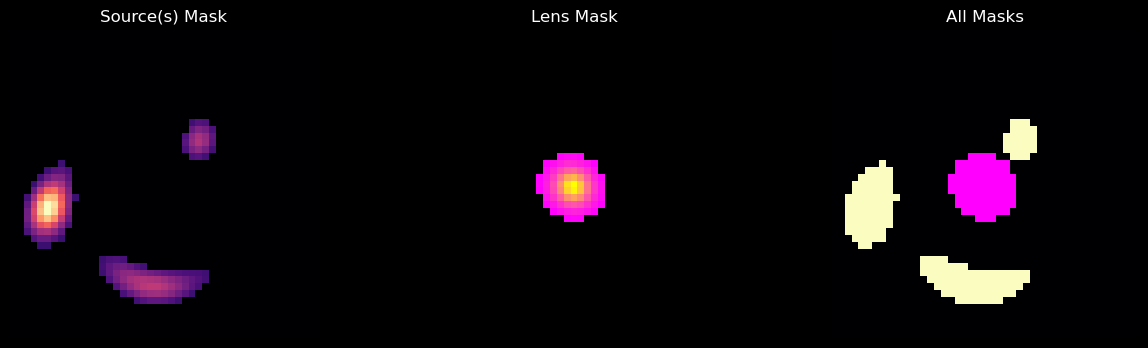

1077859177


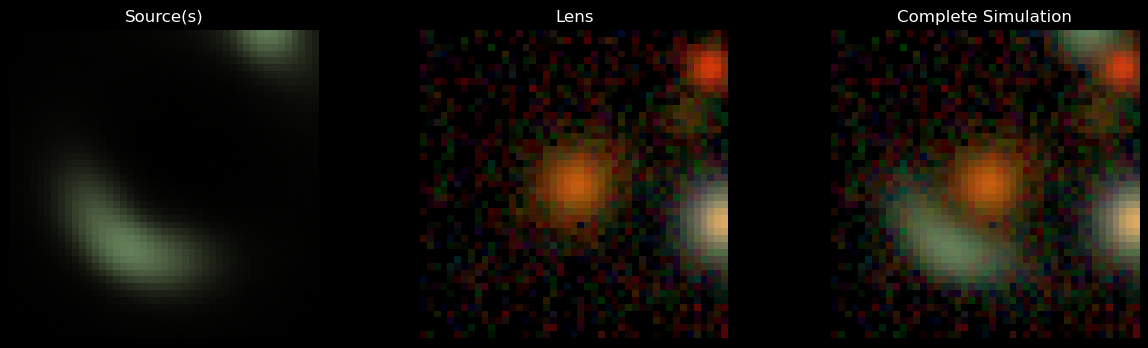

1.2 * flux radius: 4.677226832
REPEATING LOOP
REPEATING LOOP
REPEATING LOOP


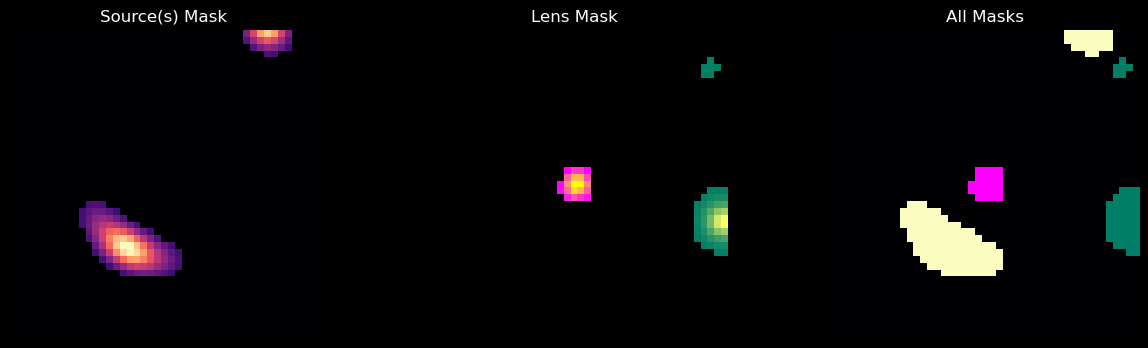

1265183867


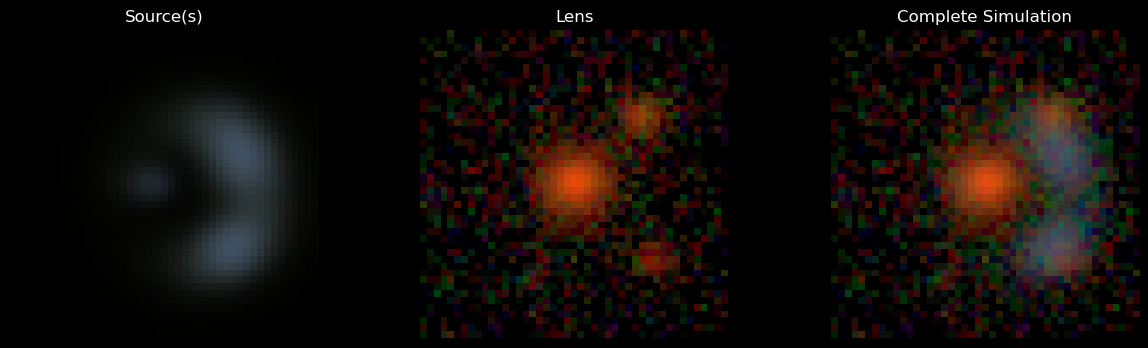

1.2 * flux radius: 4.176634504


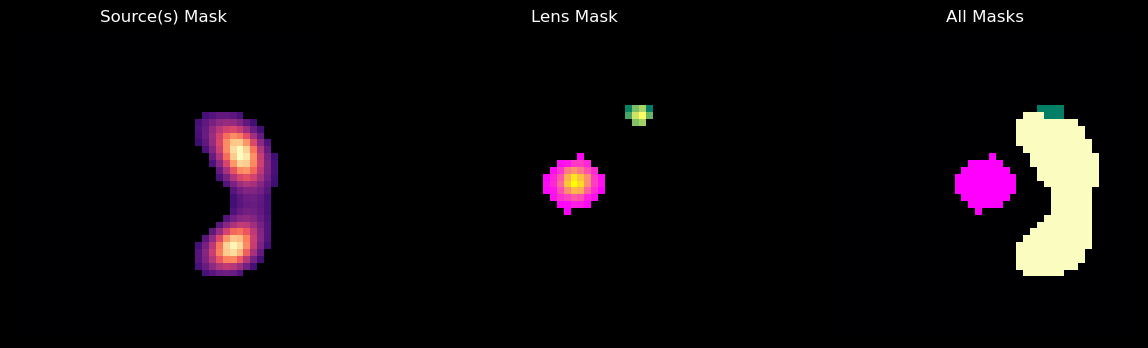

1024692586


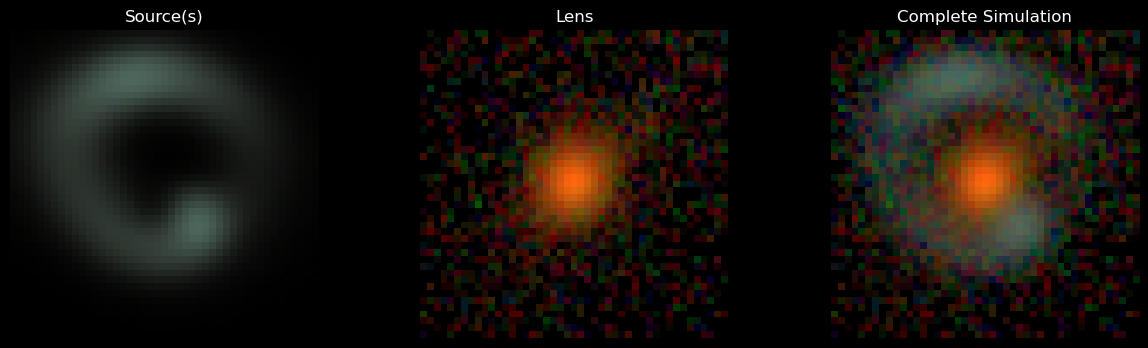

1.2 * flux radius: 4.658593084


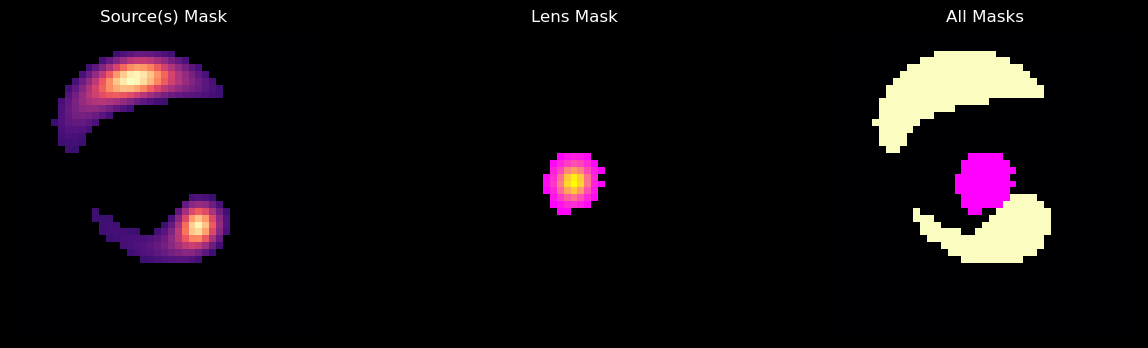

1348851768


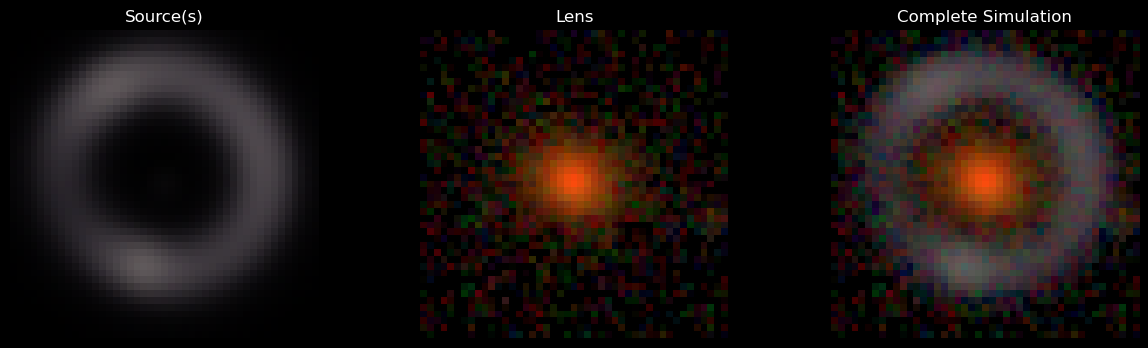

1.2 * flux radius: 5.582318116000001


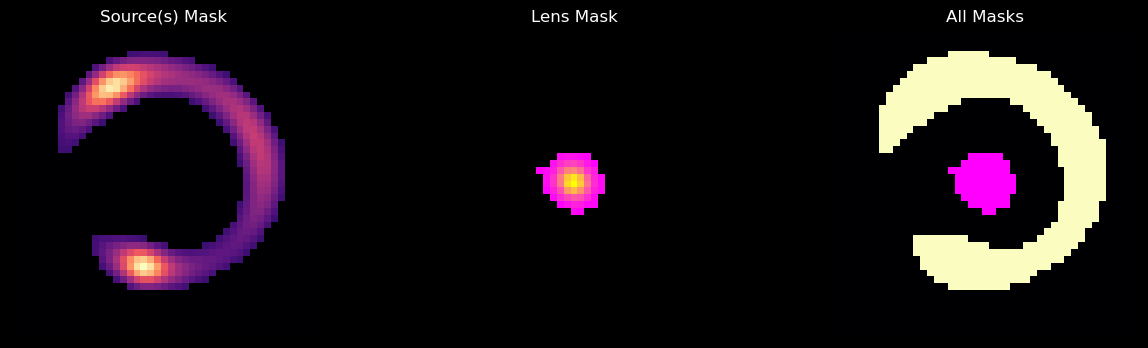

1083840052


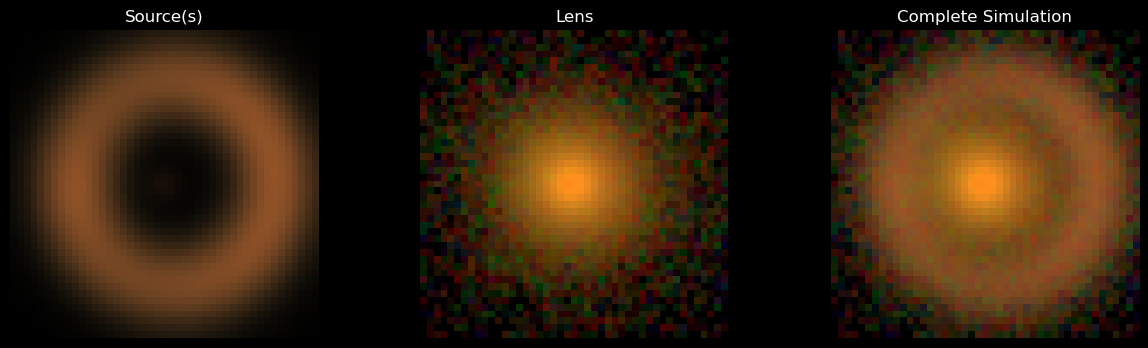

1.2 * flux radius: 6.463663868


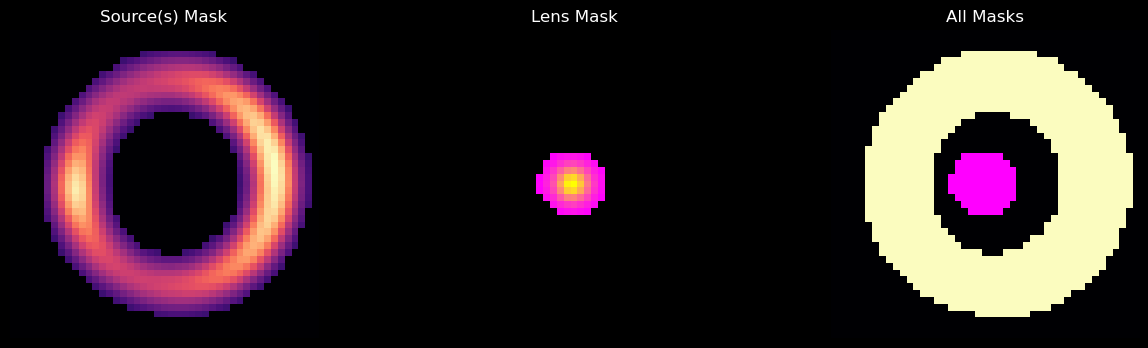

1009441420


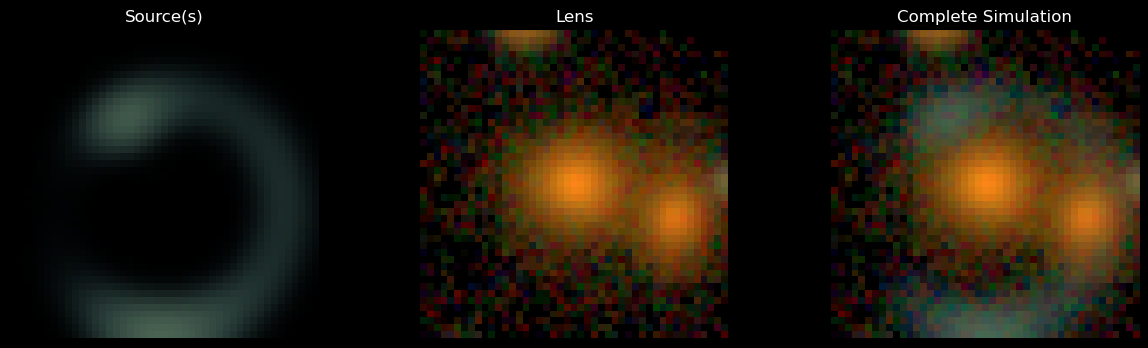

position1: 5.62847298080375


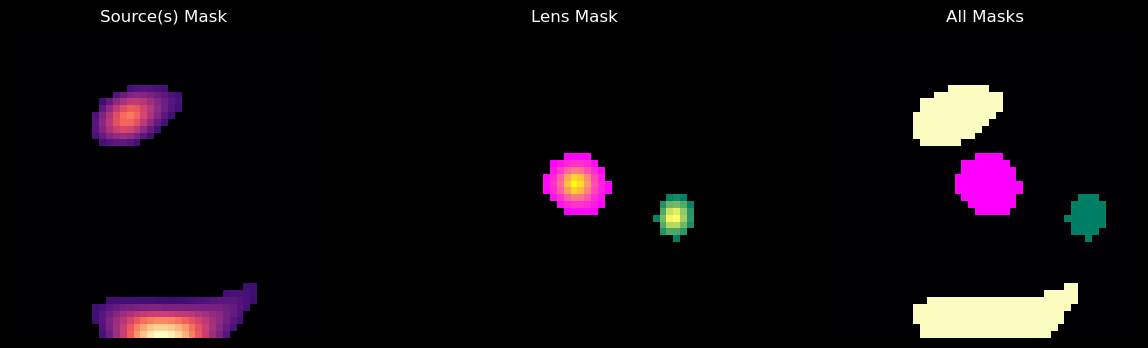

1280759777


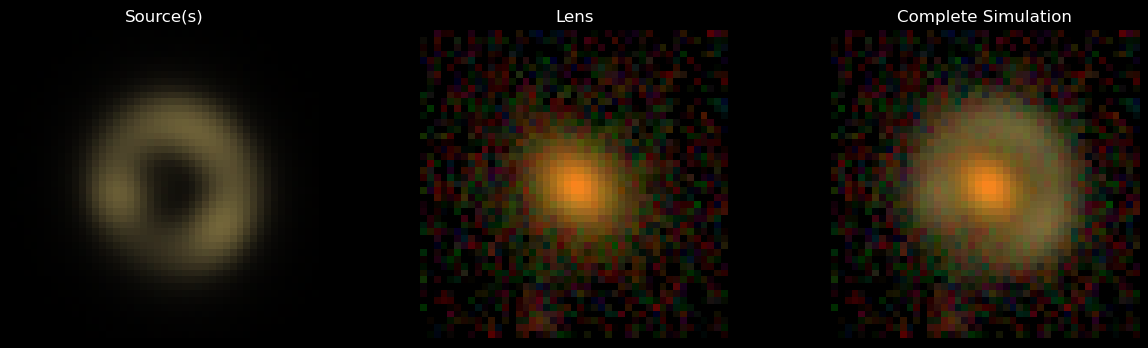

1.2 * flux radius: 4.6852764119999994


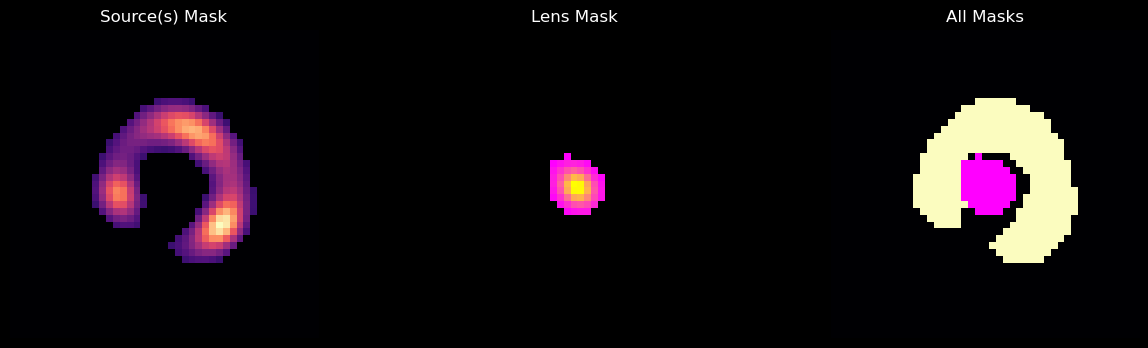

1332212748


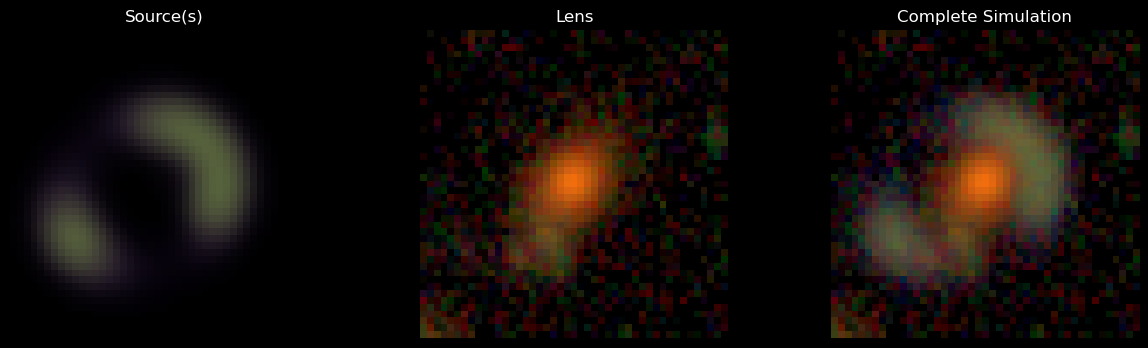

1.2 * flux radius: 5.591415024


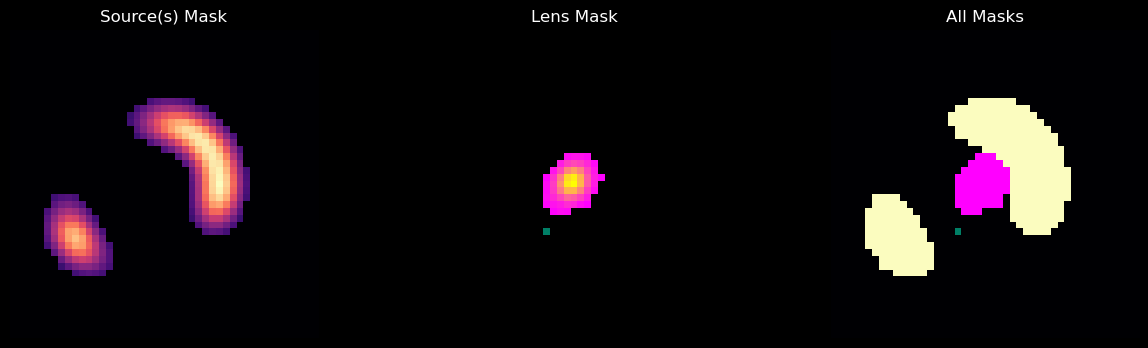

1309377824


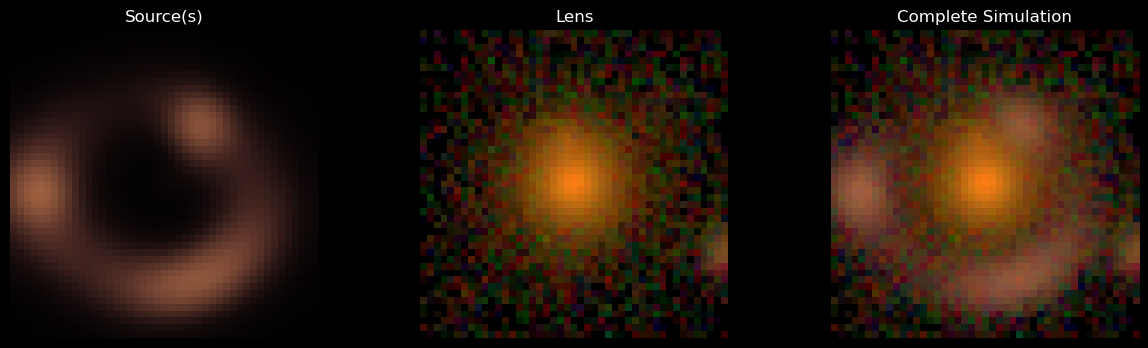

1.2 * flux radius: 7.015054508


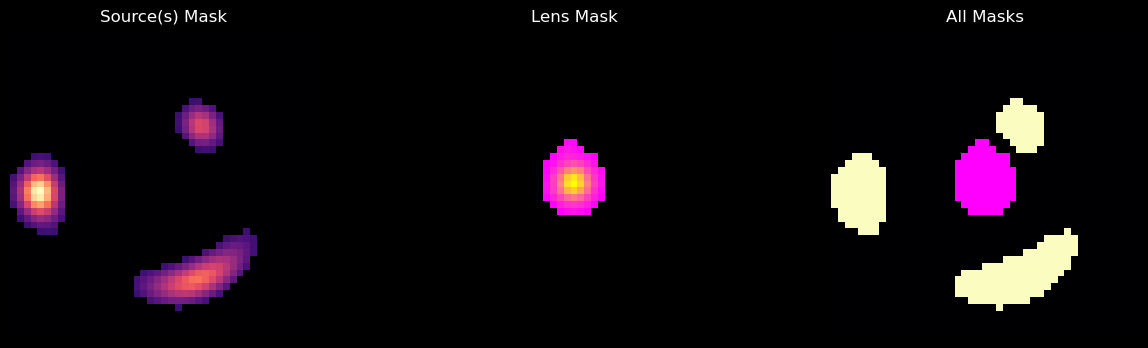

1355698399


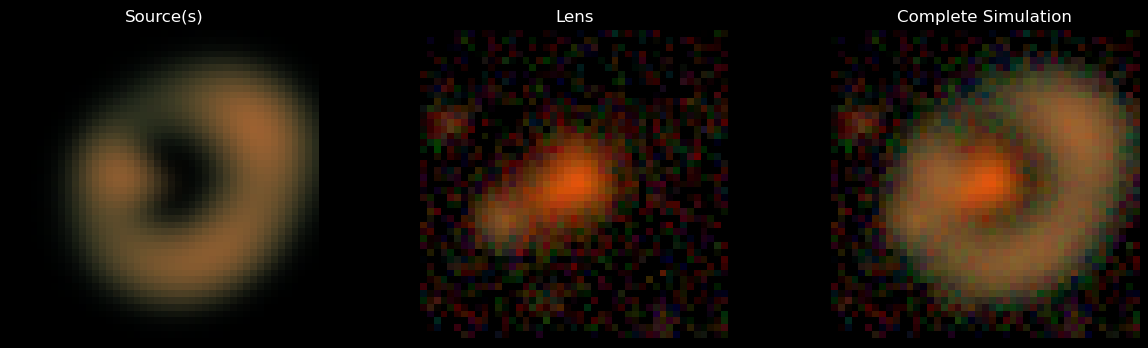

1.2 * flux radius: 5.959851455999999


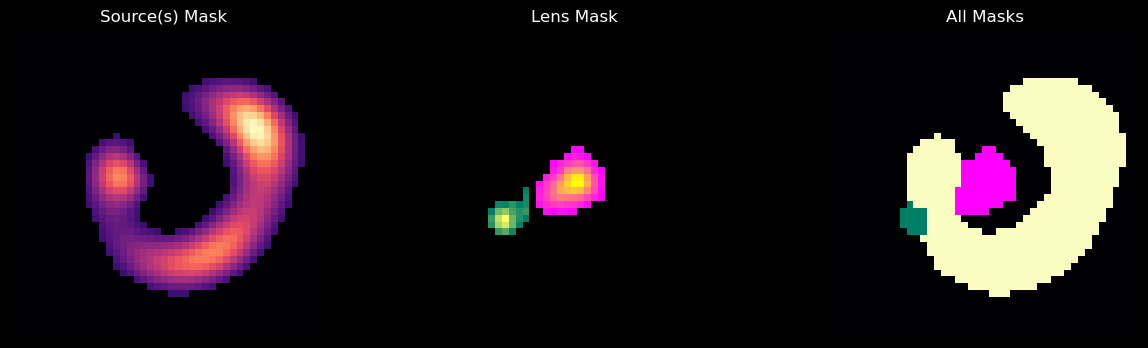

992730098


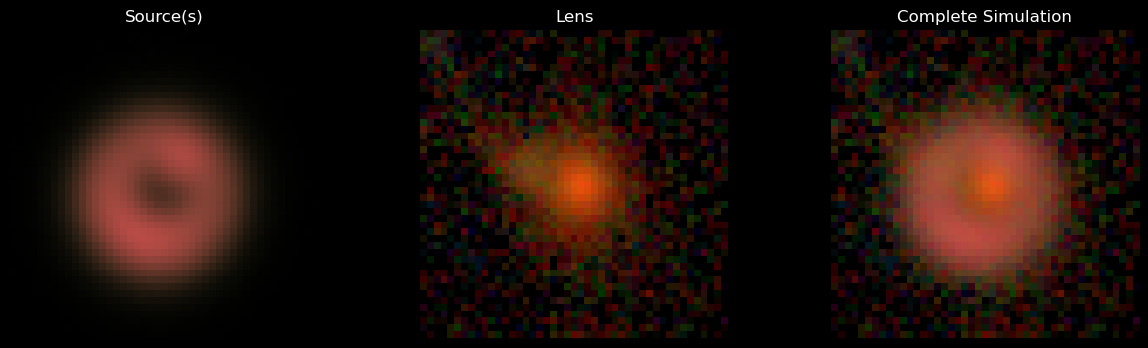

1.2 * flux radius: 7.533458899999999


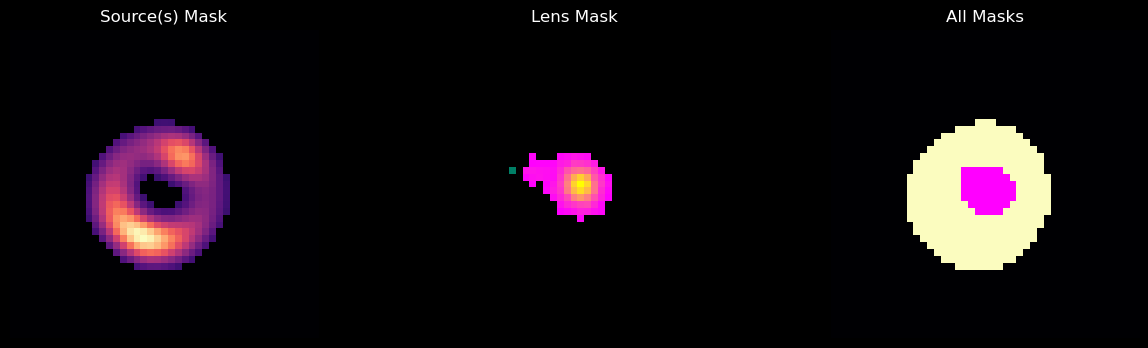

1238219746


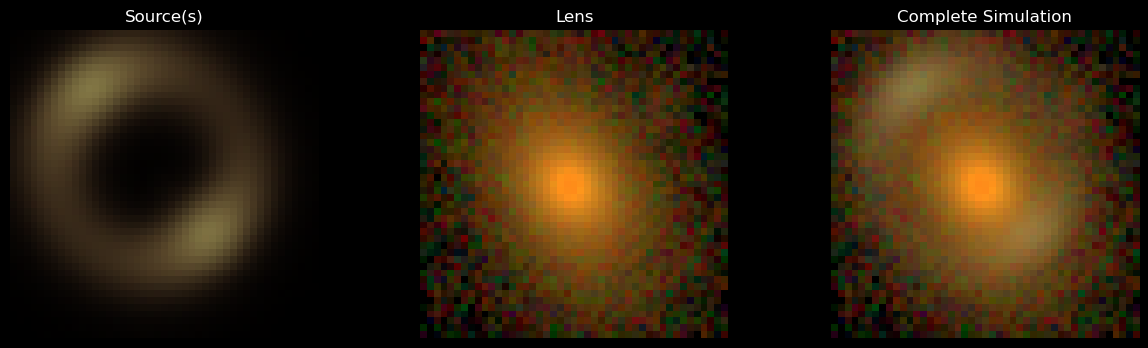

1.2 * flux radius: 8.553599548000001


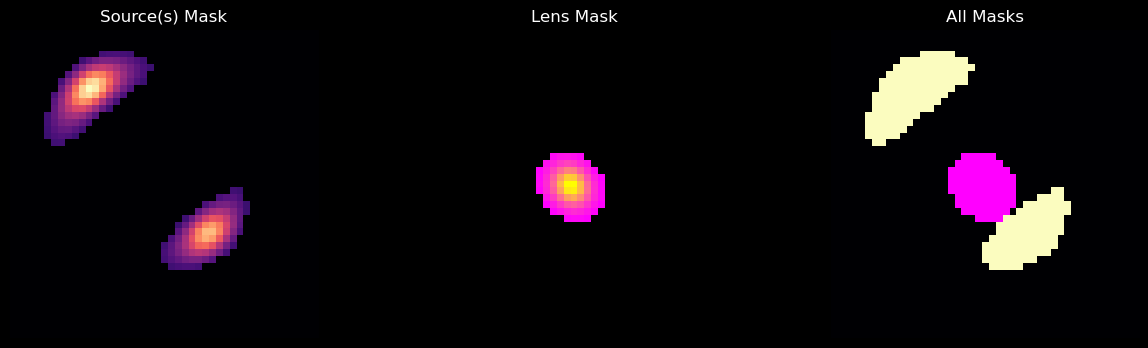

1296836334


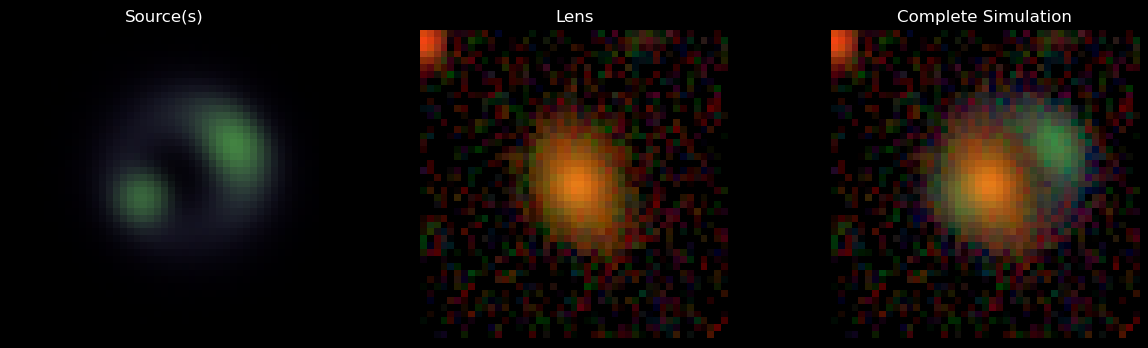

1.2 * flux radius: 4.459528636


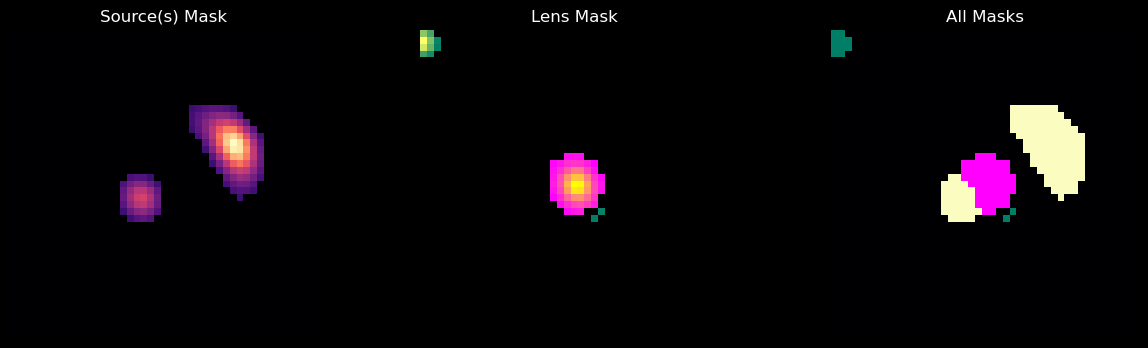

1272672232


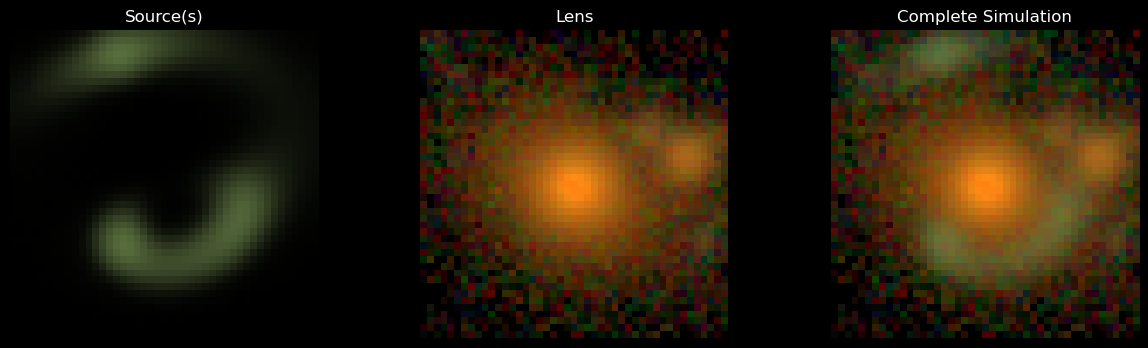

1.2 * flux radius: 7.5493673359999995


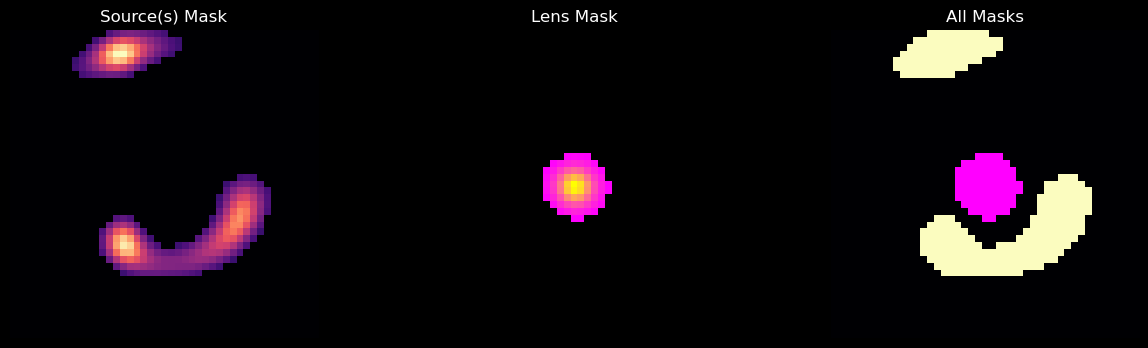

1254025035


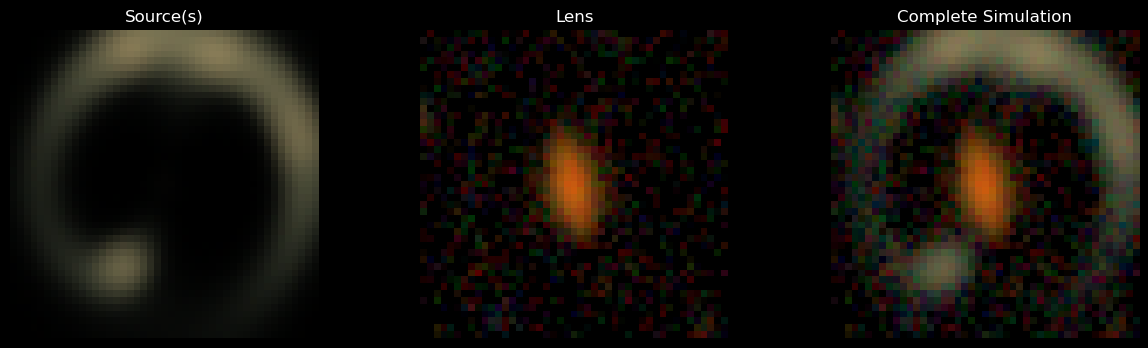

position1: 5.508054496694213


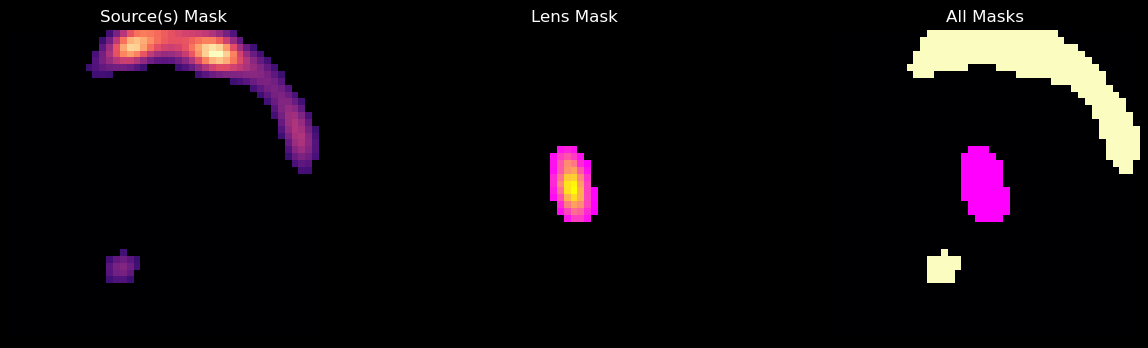

1401066536


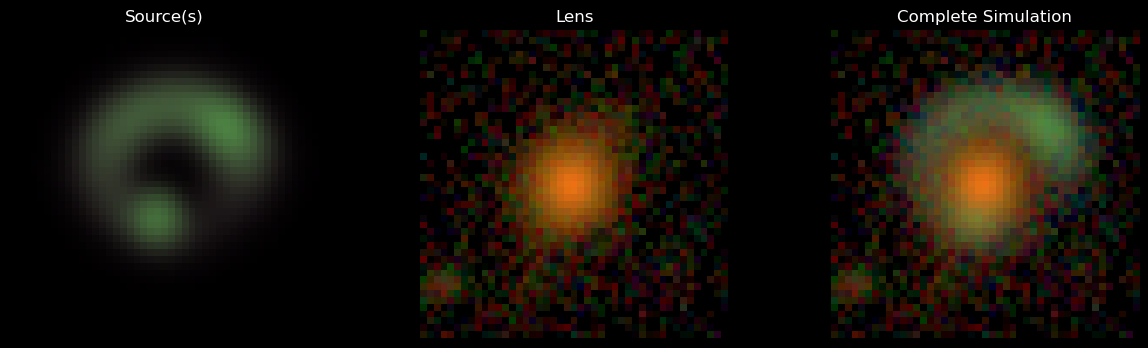

1.2 * flux radius: 4.8573390960000005


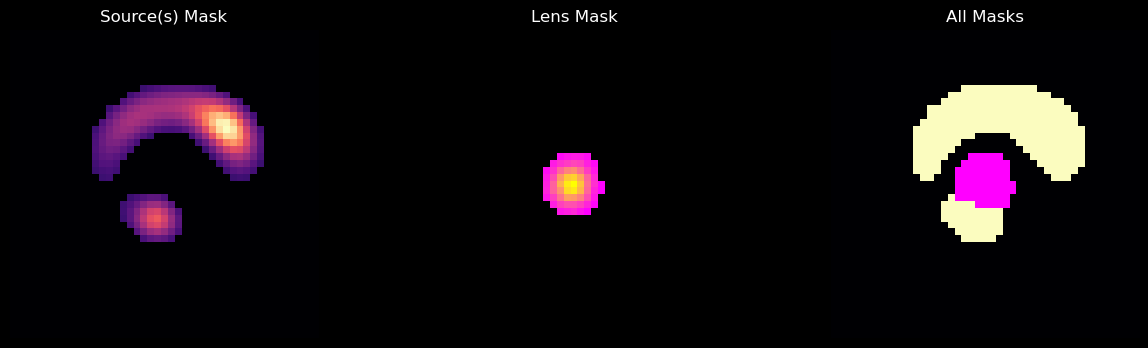

1323736471


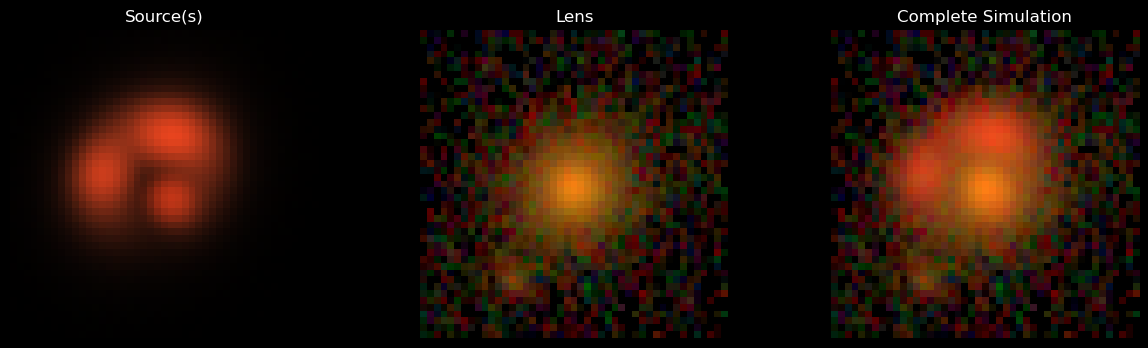

1.2 * flux radius: 6.564797208


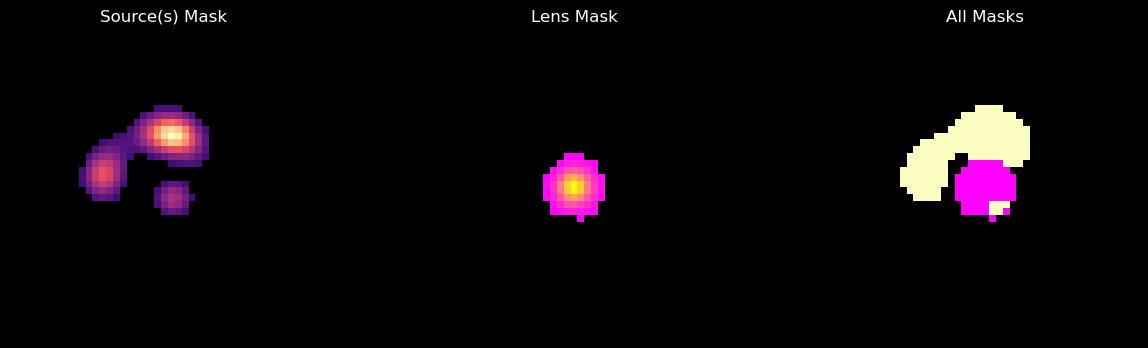

1032383943


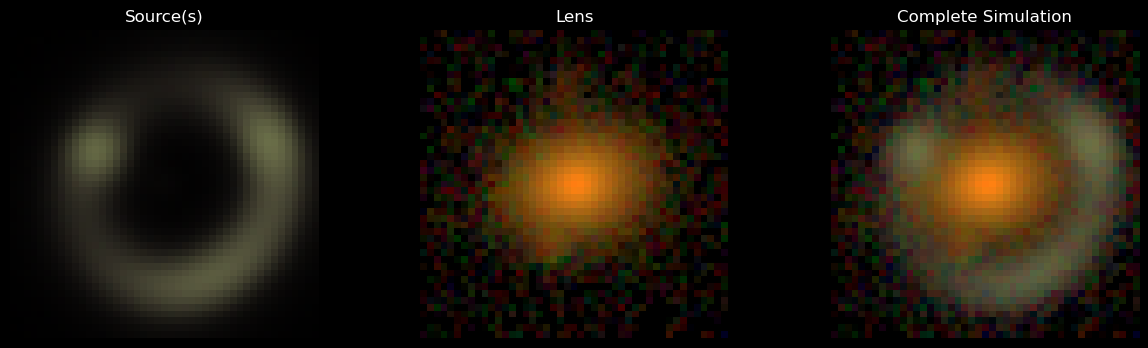

1.2 * flux radius: 6.0177013399999995


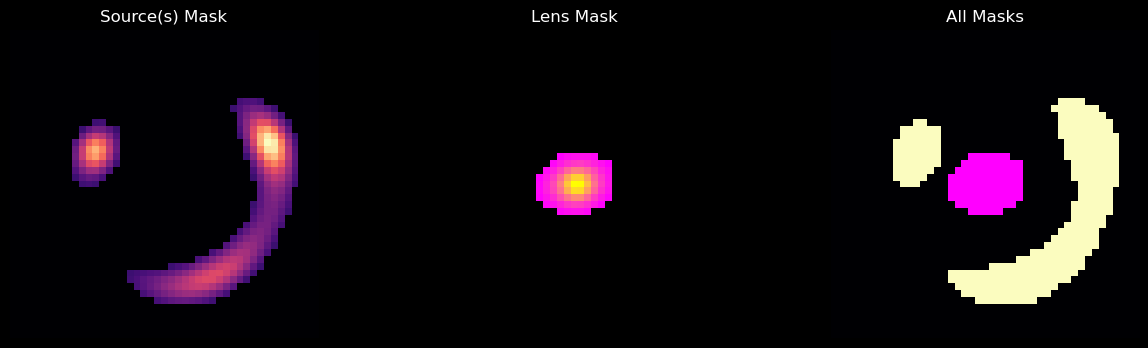

1089479885


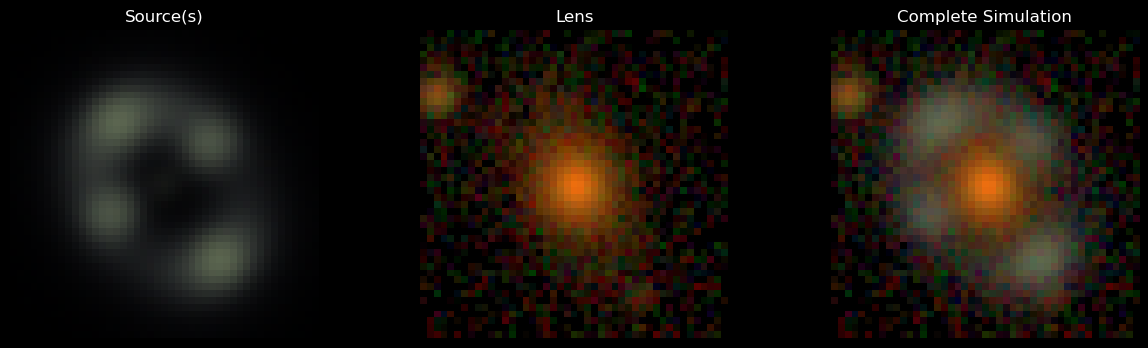

1.2 * flux radius: 5.88591404


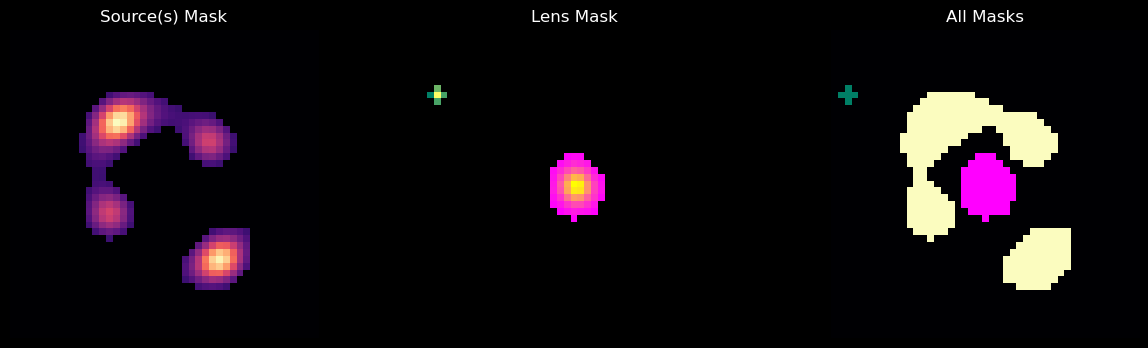

993234166


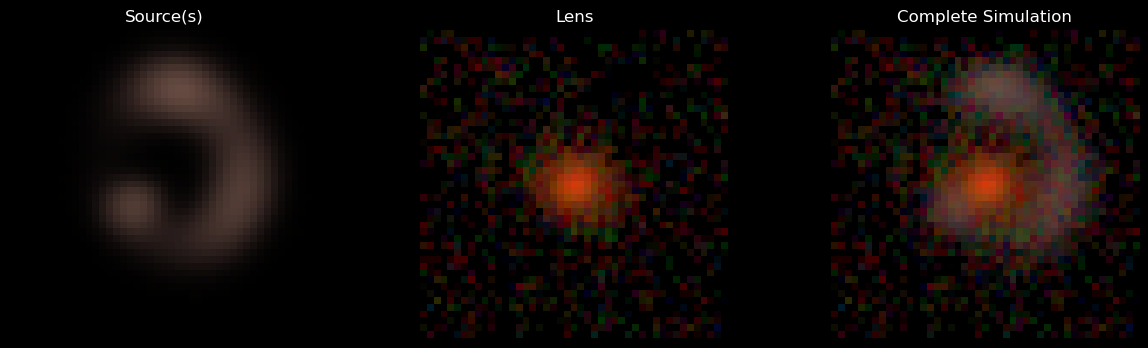

1.2 * flux radius: 4.54596844


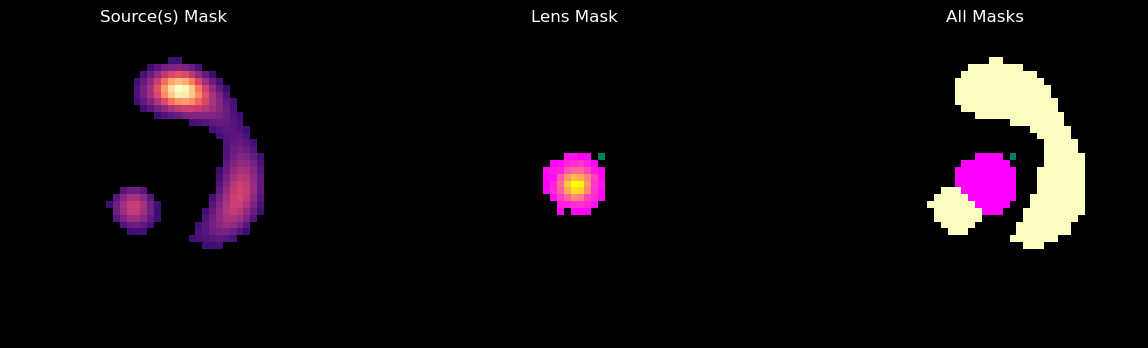

1048960121


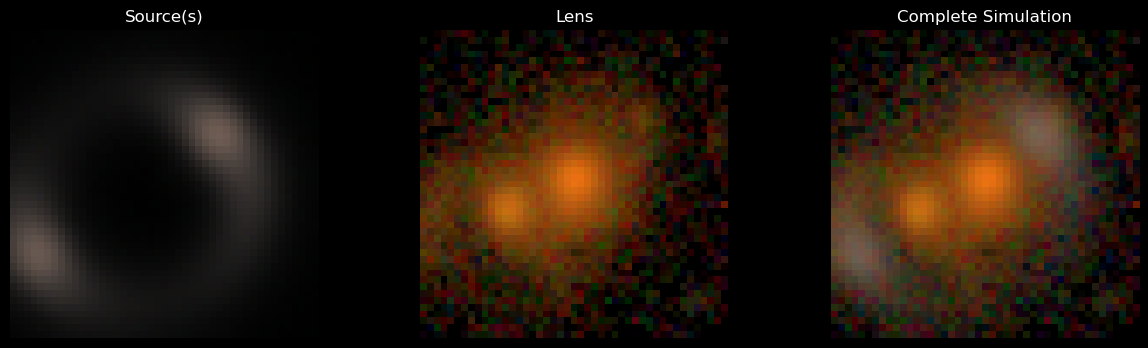

1.2 * flux radius: 7.128123284


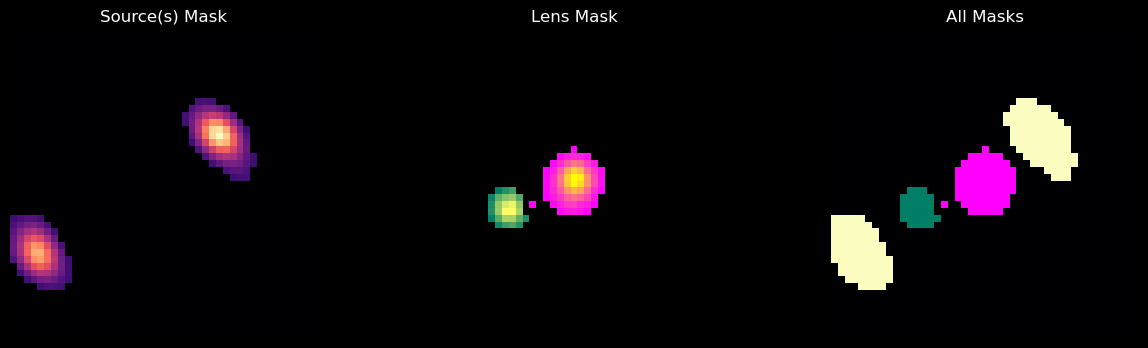

1199803671


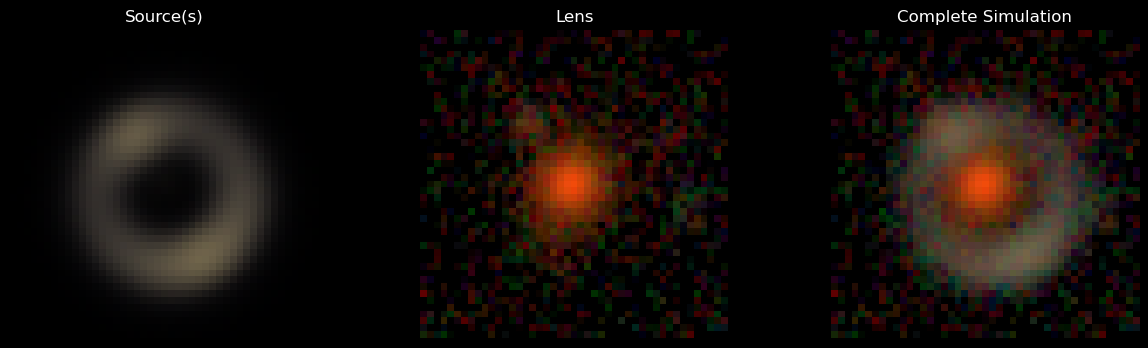

1.2 * flux radius: 5.068647576


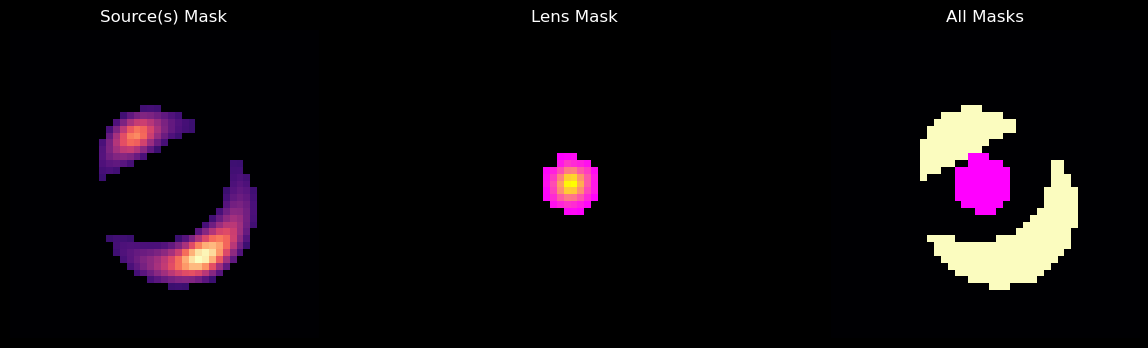

1196362141


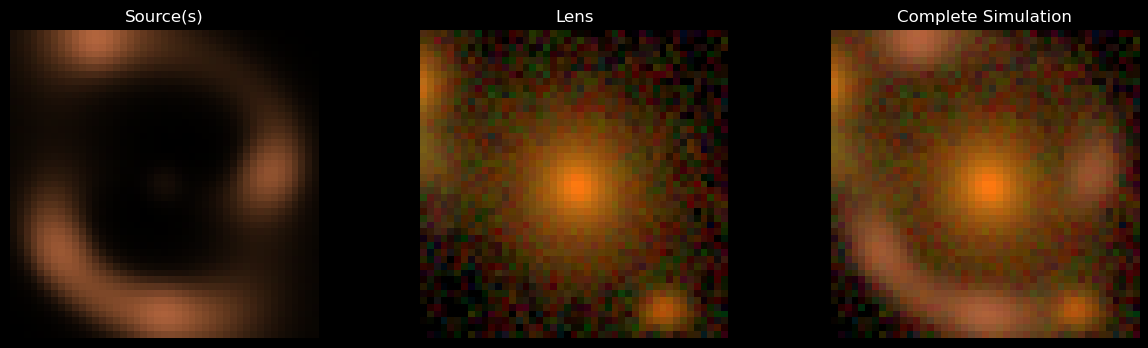

1.2 * flux radius: 11.562979508


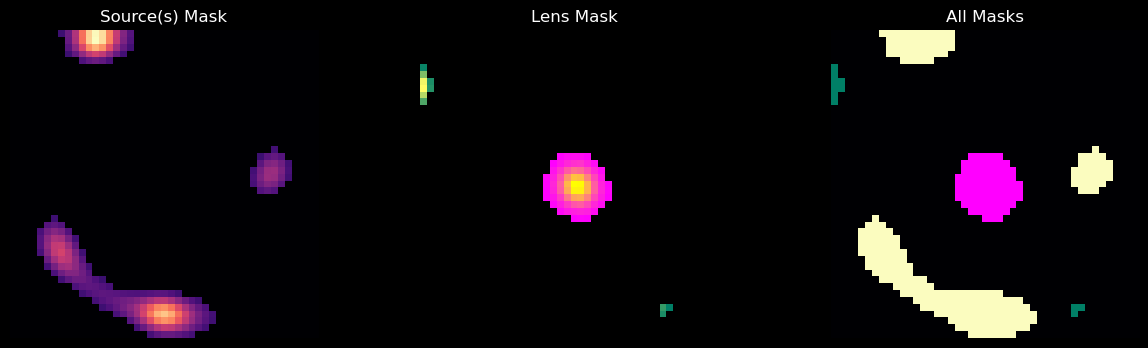

982932271


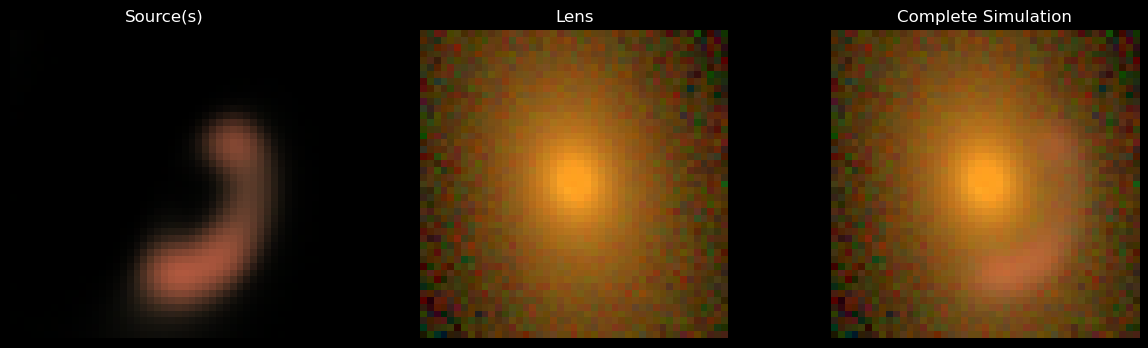

1.2 * flux radius: 14.529032896


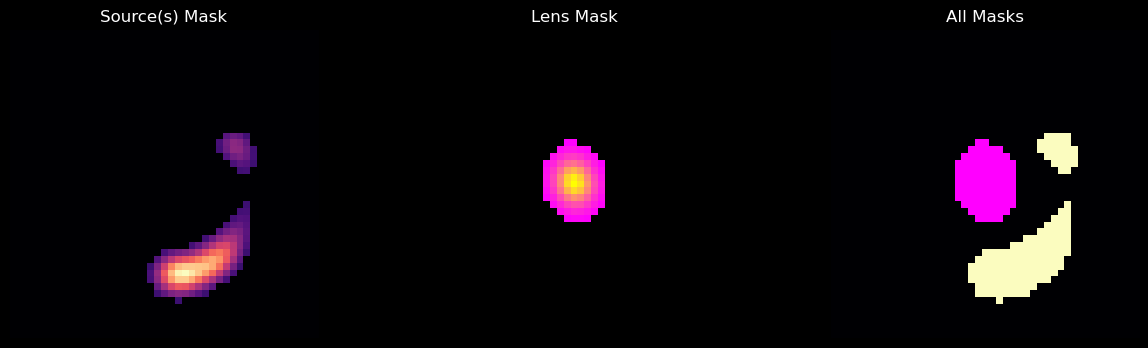

1262044917


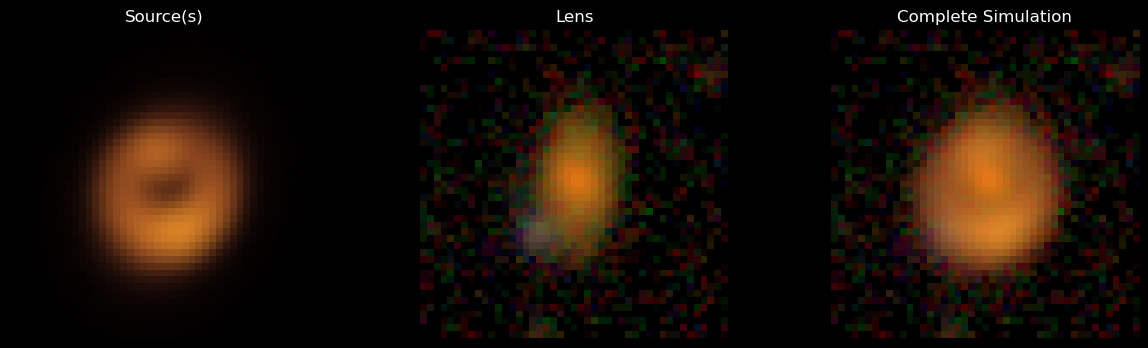

1.2 * flux radius: 5.6783731479999995


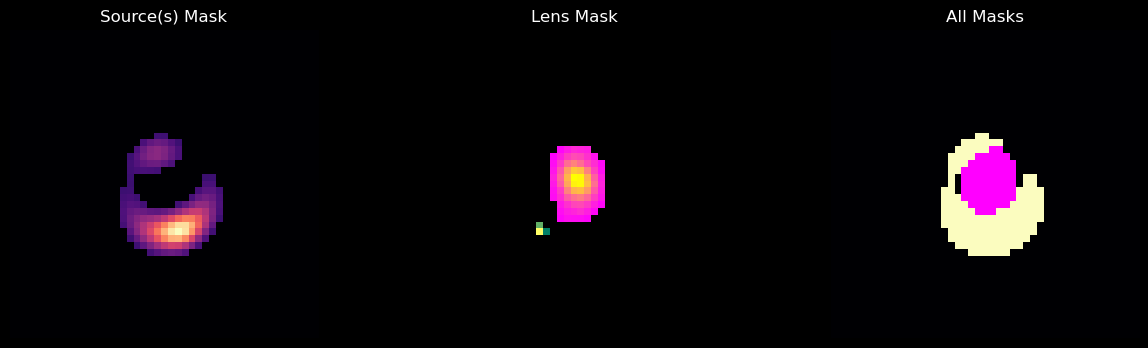

1187147109


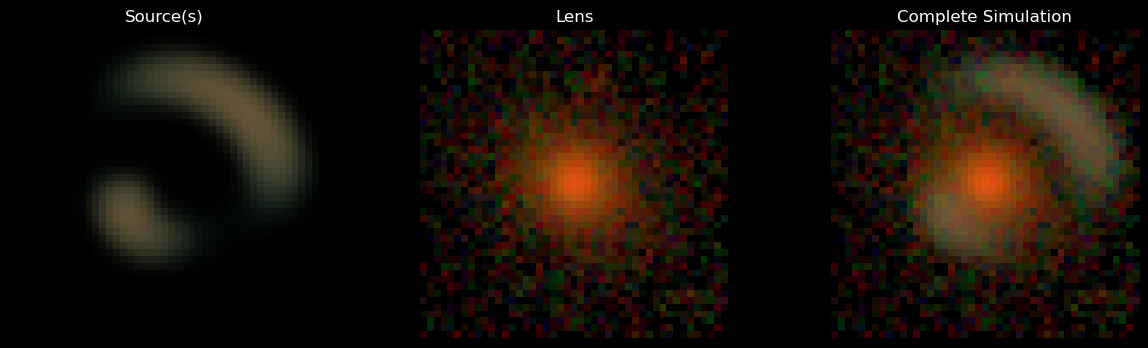

1.2 * flux radius: 11.222279172


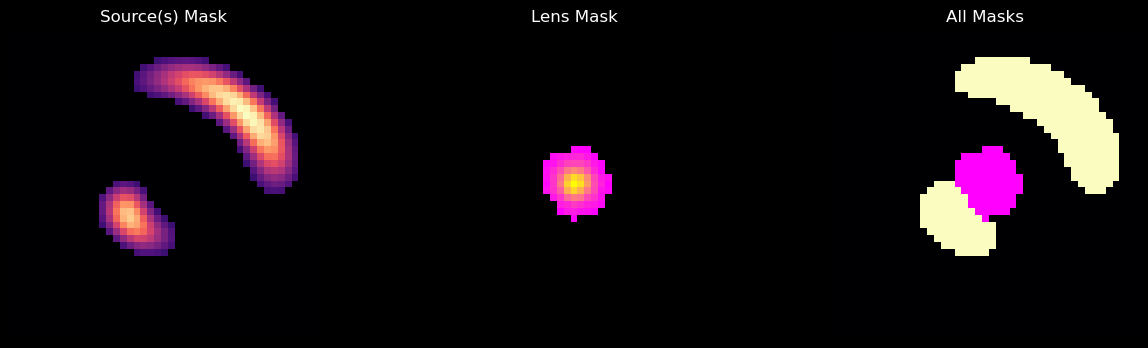

1327706638


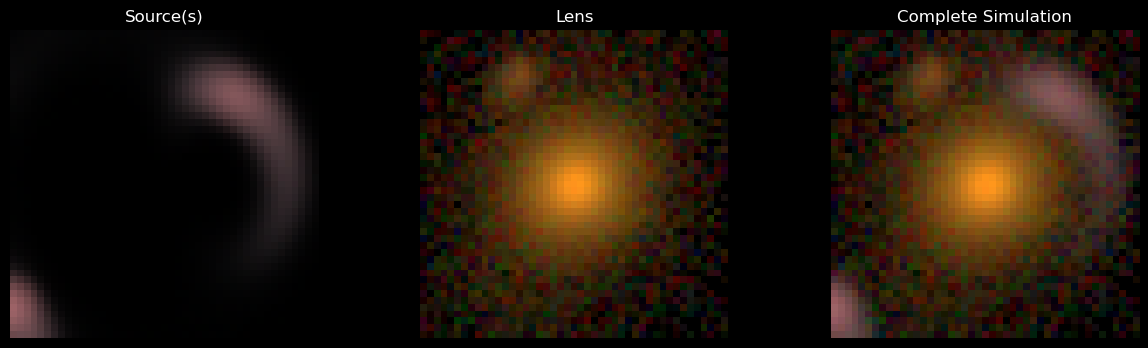

1.2 * flux radius: 6.269911768


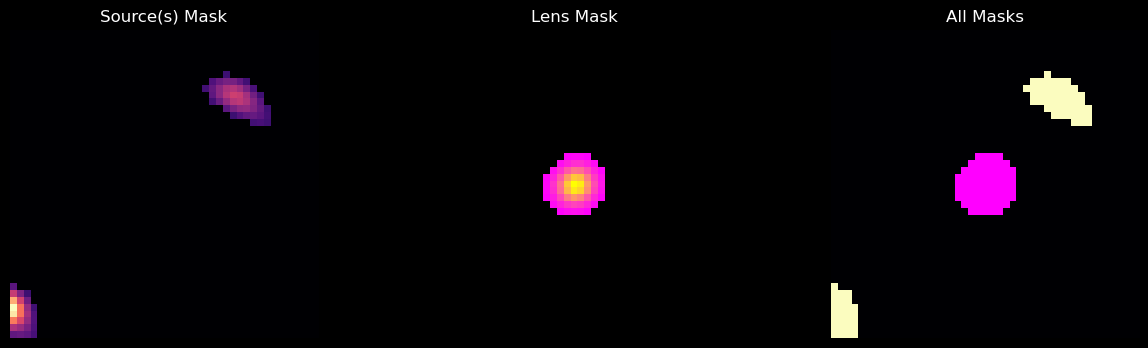

1065500432


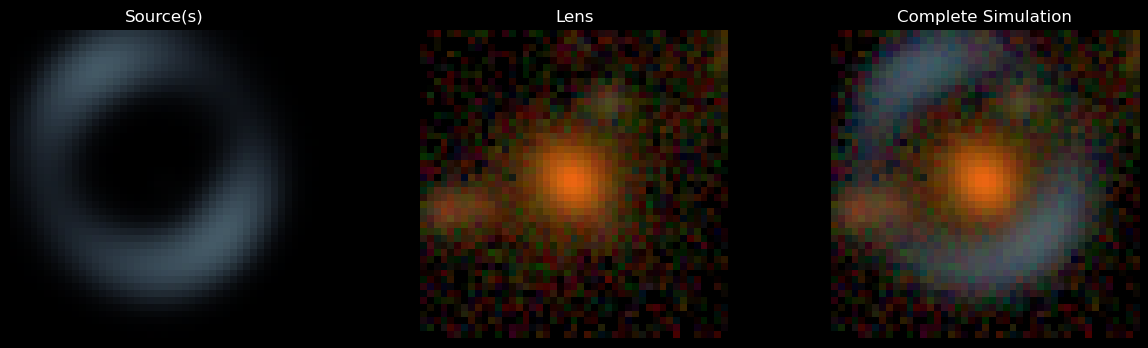

1.2 * flux radius: 6.532031628


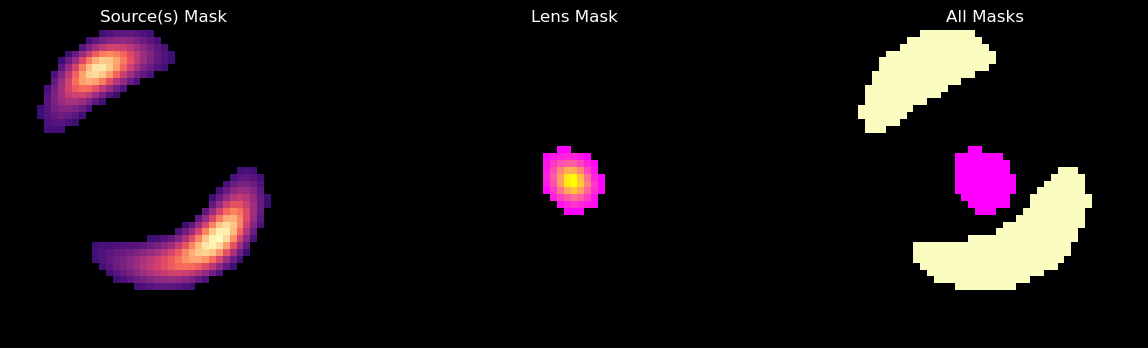

1141142956


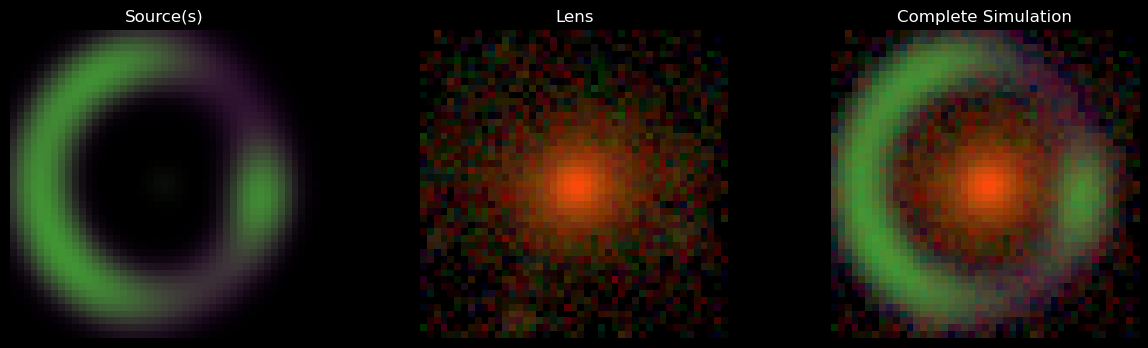

1.2 * flux radius: 9.491786004


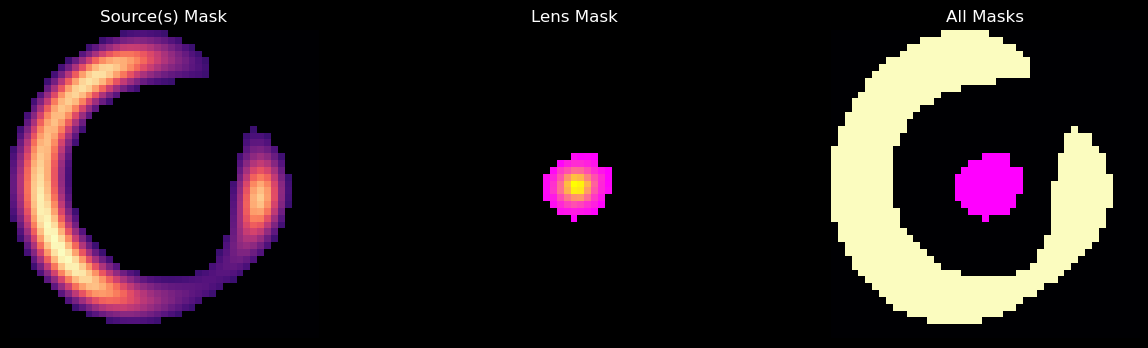

1244890003


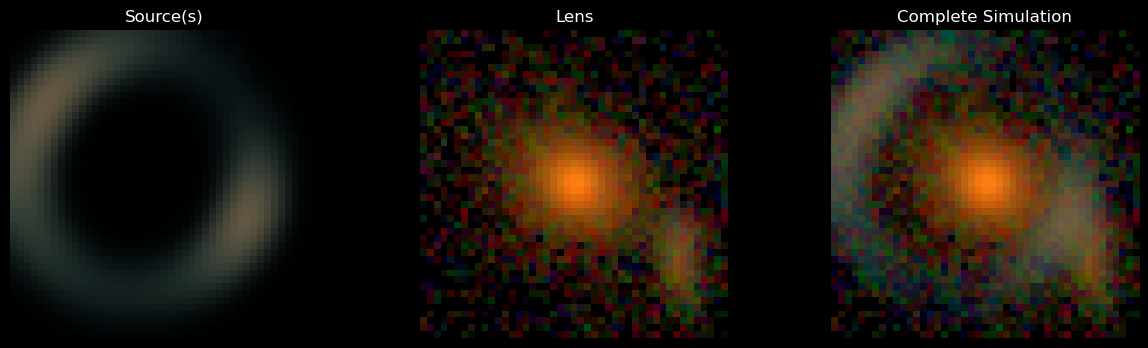

1.2 * flux radius: 5.639732932


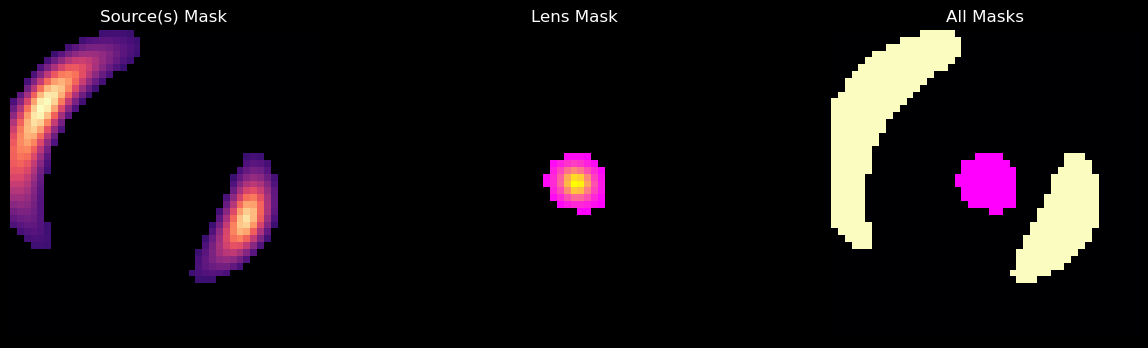

1289093018


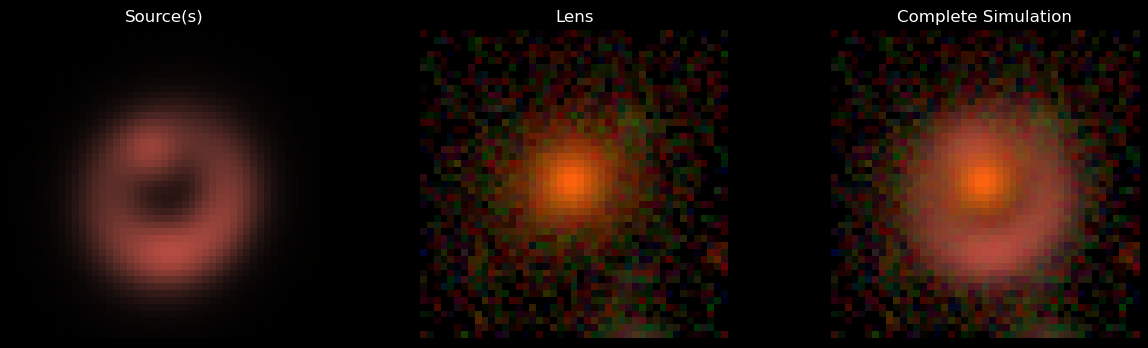

1.2 * flux radius: 6.435066603999999


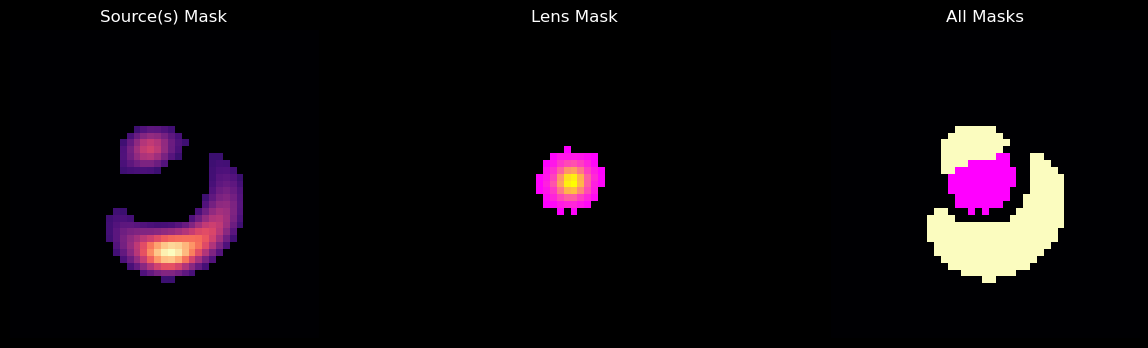

1102405732


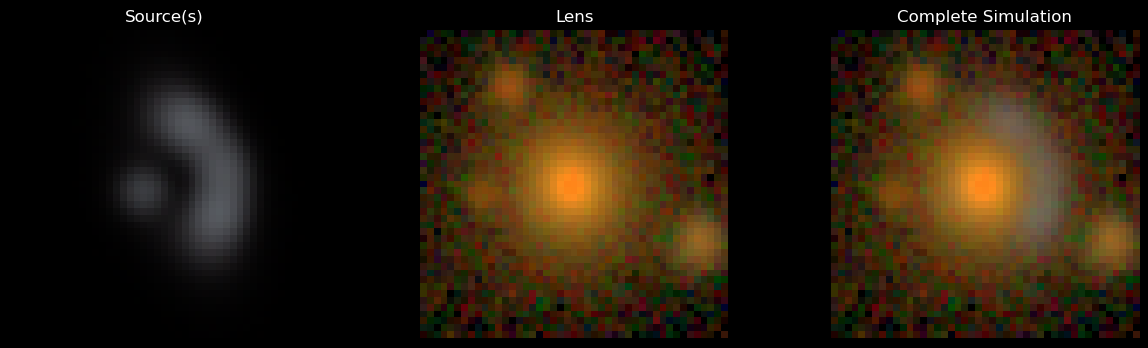

1.2 * flux radius: 7.814868923999999


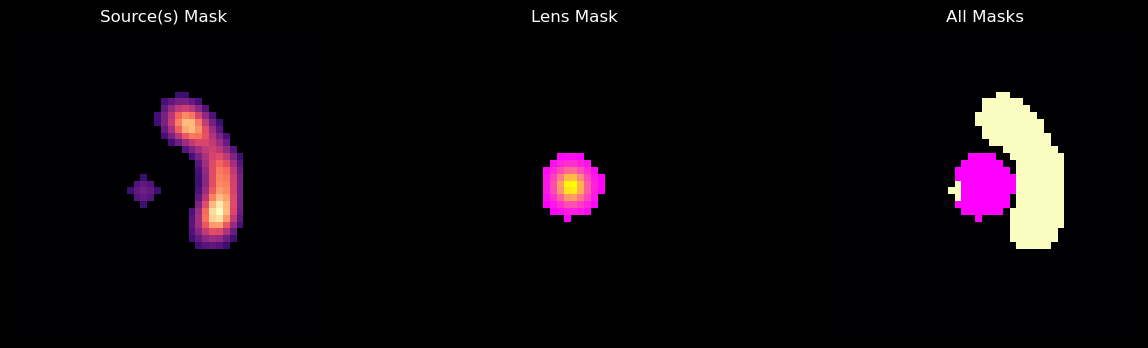

1155746582


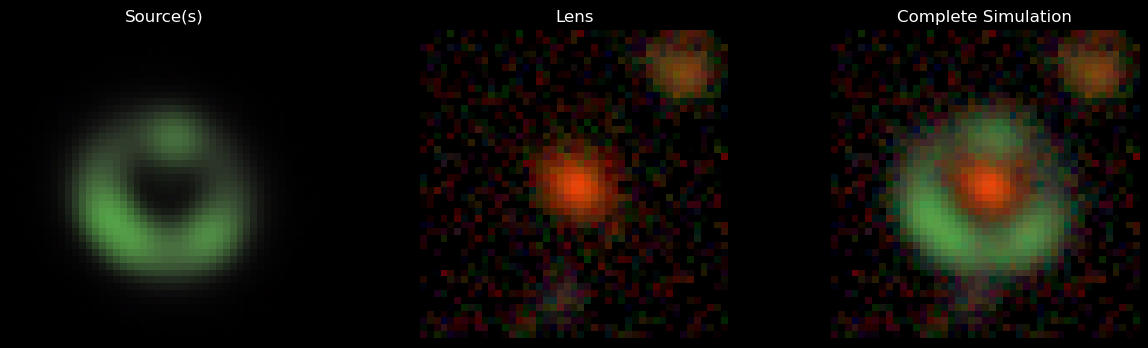

1.2 * flux radius: 3.6151589399999997


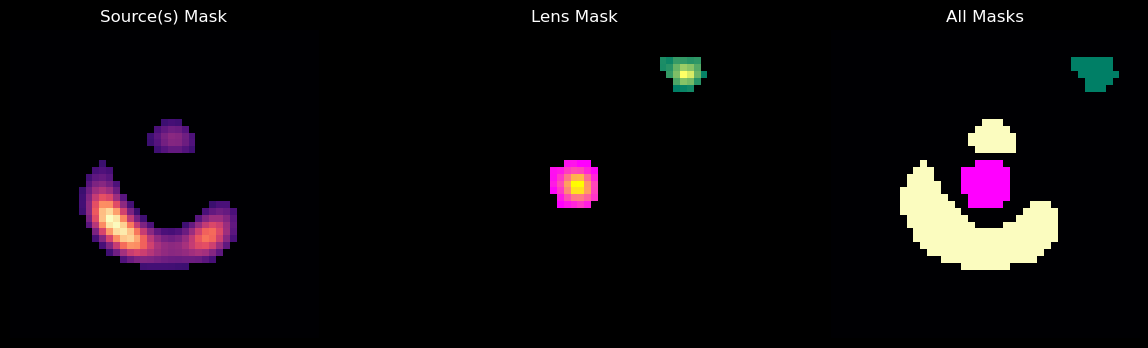

1252530119


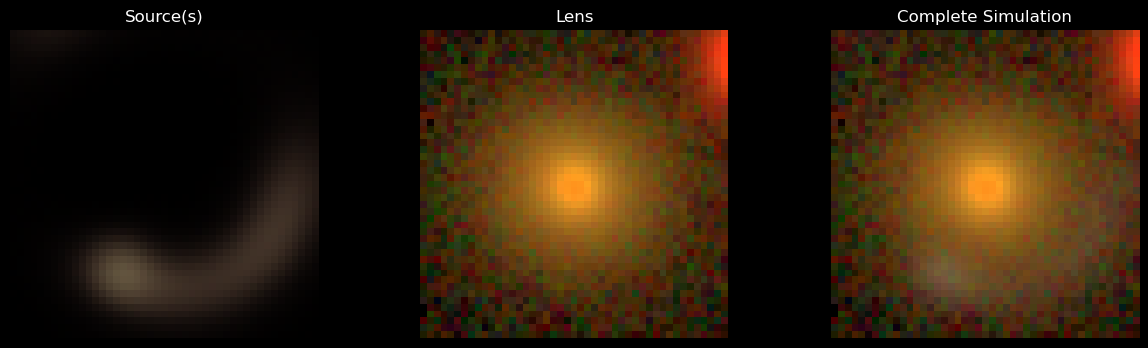

1.2 * flux radius: 8.554732516000001


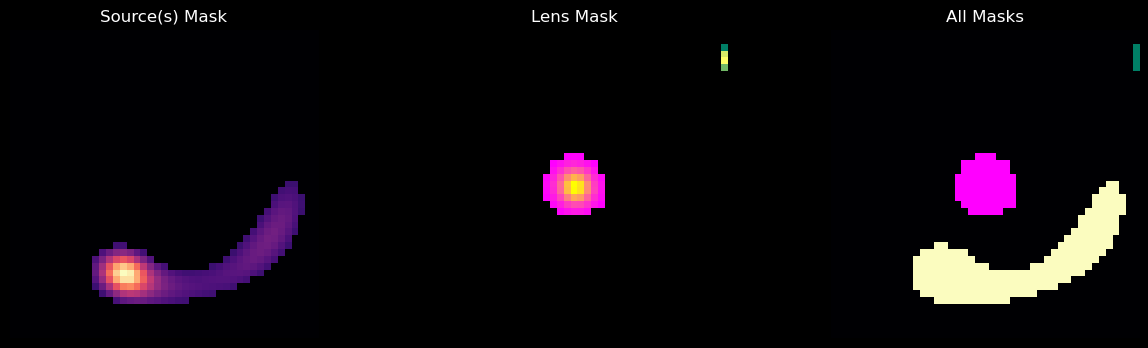

1092350465


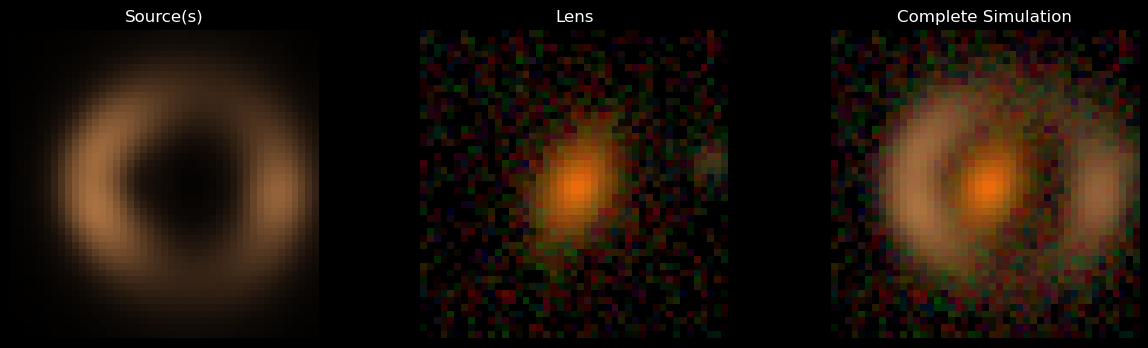

1.2 * flux radius: 4.956778528


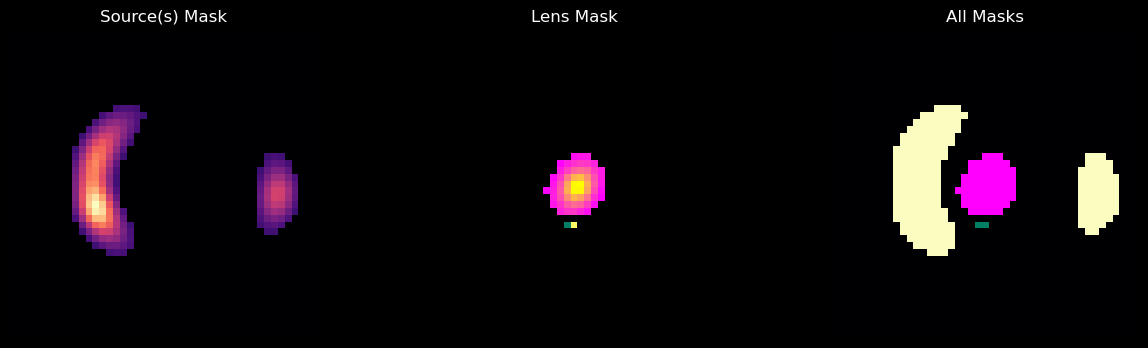

1042520901


In [11]:
num_label = 40
masks_complete, masks_source, masks_lens = masking_all(NUM_PIX, num_label)
# images = [complete_sim, source_sim, lens_sim, masks_complete, masks_source, masks_lens] 
# write_fit_file('dump', images, data)

In [12]:
if script == False:
    plt.close('all')

**Error Statistics**
| | False Positive | False Negative | Total |
|---------------|----------------|----------------|-------|
| Minor | 0.6% | 1.7% | 2.3% |
| Major | 0.2% | 1.0% | 1.2% |
| Total | 0.8% | 2.7% | 3.5% |

<dl>
  <dt>Key</dt>
  <dd>False Positive = pixel marked as 'LENS' when should be 'NOISE'</dd>
  <dd>False Negative = pixel marked as 'NOISE' when should be 'LENS</dd>
  <dd>Minor = less than 5 pixels misclassified</dd>
  <dd>Major = 5 or more pixels misclassified</dd>
</dl>





**Current Issues**
* Inefficient because of all the for/while loops
* Struggles with highly elliptical galaxies

**Ideas for dealing with possible double lens or L.O.S. mass that could change lensing potential:**
* check for multiple local maxima => flag as potential double lens, then send to separate model or model by hand?